# Lab ML for DS SS23
## Project 1
#### Jan Jascha Jestel (5547158)
#### Mustafa Suman (5564676)
#### Gabriele Inciuraite (5208806)

In [1]:
import pandas as pd
import numpy as np
import math

from scipy.stats import spearmanr
from scipy.spatial import distance

from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from yellowbrick.cluster import KElbowVisualizer

import p1_functions

# Set random seed
np.random.seed(42)

# 1. Loading the Data, Preprocessing, Initial Data Analysis

In [2]:
df = pd.read_csv(r"https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv")
df_og = df.copy()
df

Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
0          2       3  12669   9656     7561     214              2674   
1          2       3   7057   9810     9568    1762              3293   
2          2       3   6353   8808     7684    2405              3516   
3          1       3  13265   1196     4221    6404               507   
4          2       3  22615   5410     7198    3915              1777   
..       ...     ...    ...    ...      ...     ...               ...   
435        1       3  29703  12051    16027   13135               182   
436        1       3  39228   1431      764    4510                93   
437        2       3  14531  15488    30243     437             14841   
438        1       3  10290   1981     2232    1038               168   
439        1       3   2787   1698     2510      65               477   

     Delicassen  
0          1338  
1          1776  
2          7844  
3          1788  
4          5185  
..          ...  
435        2204  
436        2346  
437        1867  
438        2125  
439          52  

[440 rows x 8 columns]

In [3]:
# Correct the typo
df.rename(columns = {'Delicassen':'Delicatessen'}, inplace = True)

#Describe the dataframe
df.describe()

# Number of distinct elements per column
#df.nunique()

# Check for NaNs
#df.isnull().values.any()

Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.000000      3.000000   
25%      1.000000    2.000000    3127.750000   1533.000000   2153.000000   
50%      1.000000    3.000000    8504.000000   3627.000000   4755.500000   
75%      2.000000    3.000000   16933.750000   7190.250000  10655.750000   
max      2.000000    3.000000  112151.000000  73498.000000  92780.000000   

             Frozen  Detergents_Paper  Delicatessen  
count    440.000000        440.000000    440.000000  
mean    3071.931818       2881.493182   1524.870455  
std     4854.673333       4767.854448   2820.105937  
min       25.000000          3.000000      3.000000  
25%      742.250000        256.750000    408.250000  
50%     1526.000000        816.500000    965.500000  
75%     3554.250000       3922.000000   1820.250000  
max    60869.000000      40827.000000  47943.000000

#### Attribute Information:
CHANNEL: customers' Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal)
REGION: customers' Region - Lisnon, Oporto or Other (Nominal)
FRESH: annual spending (m.u.) on fresh products (Continuous)
MILK: annual spending (m.u.) on milk products (Continuous)
GROCERY: annual spending (m.u.)on grocery products (Continuous)
FROZEN: annual spending (m.u.)on frozen products (Continuous)
DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous)

In [4]:
# Get nominal and numerical attributes
dtype = df.dtypes
cat_features = ["Channel", "Region"] #df[["Channel", "Region"]]
num_features = df.drop(columns=["Channel", "Region"]).columns.tolist()

print("Nominal features:", cat_features)
print("Numerical features:", num_features)

Nominal features: ['Channel', 'Region']
Numerical features: ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']


## 1.1. Basic statistical visualisations of the data

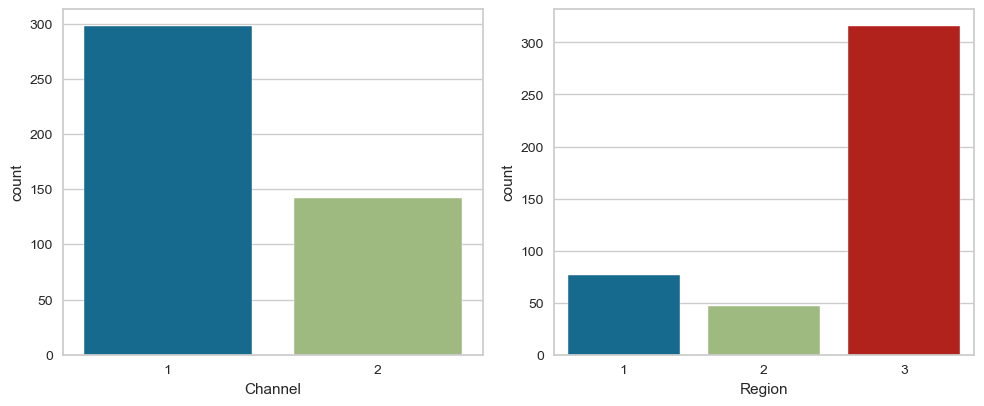

In [5]:
# Plot distributions of attributes: NOMINAL (barplots)
p1_functions.cat_plot(df, cat_features)

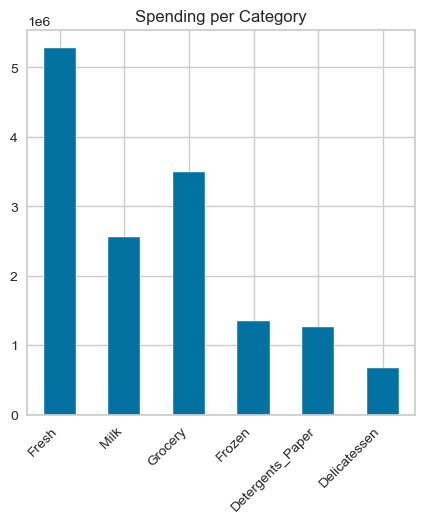

In [6]:
# Plot overall spending per category
fig = plt.figure(figsize=(5,5))
df[num_features].sum().plot.bar()
plt.title("Spending per Category")
plt.xticks(rotation=45, ha='right')
plt.show()

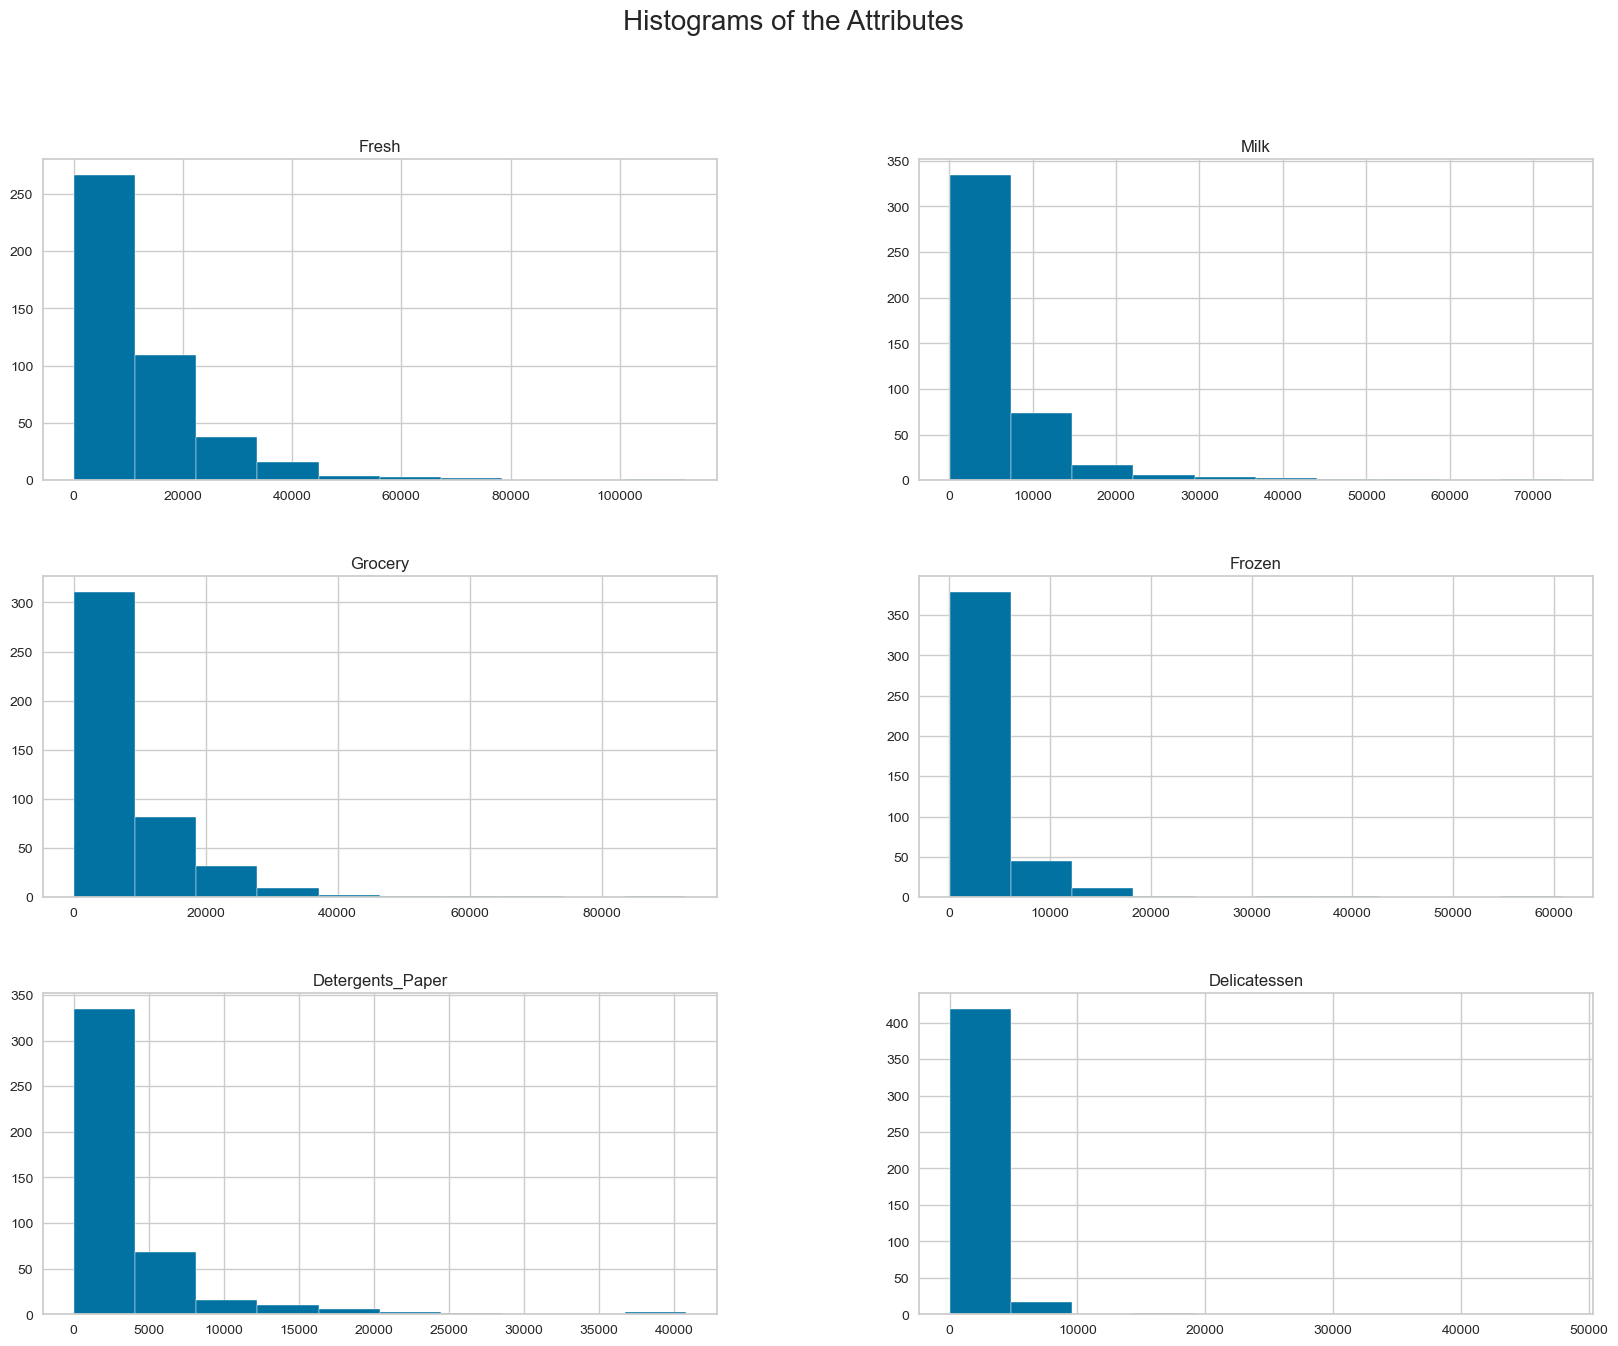

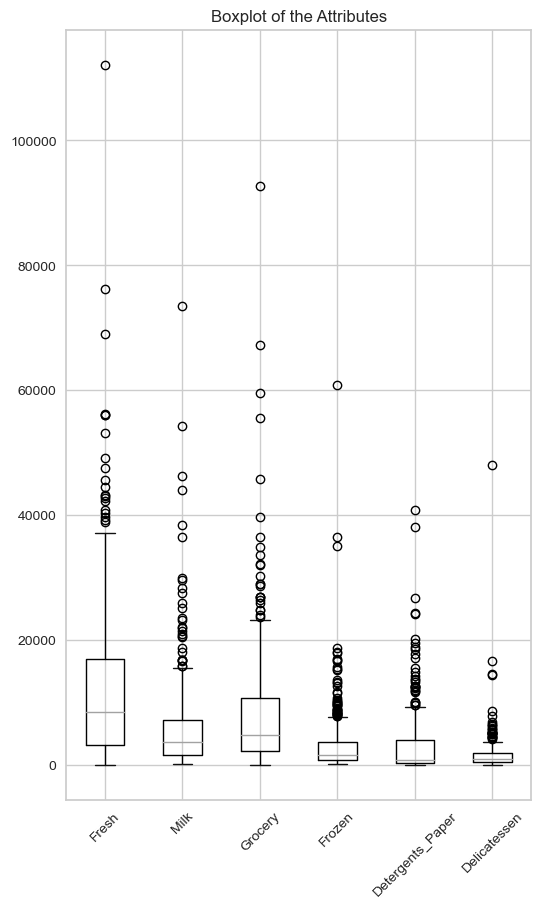

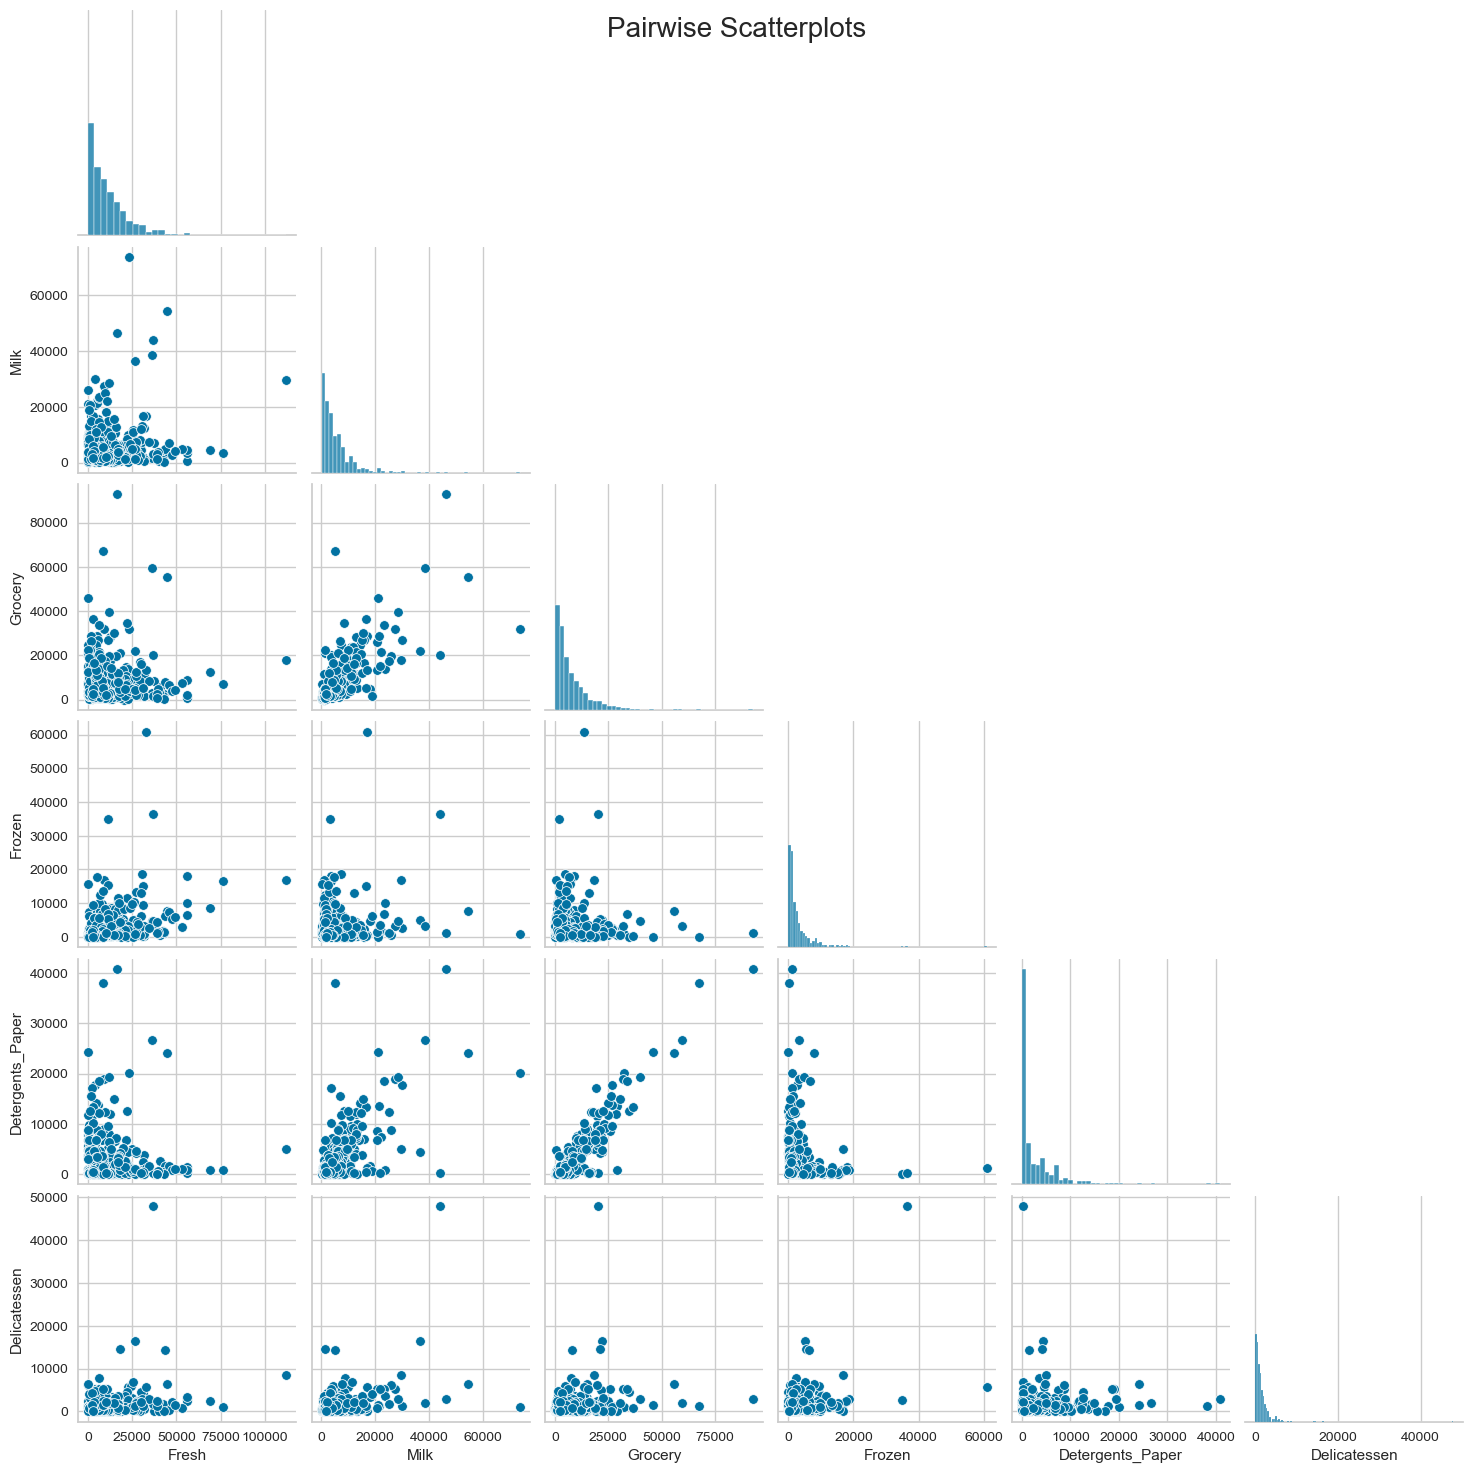

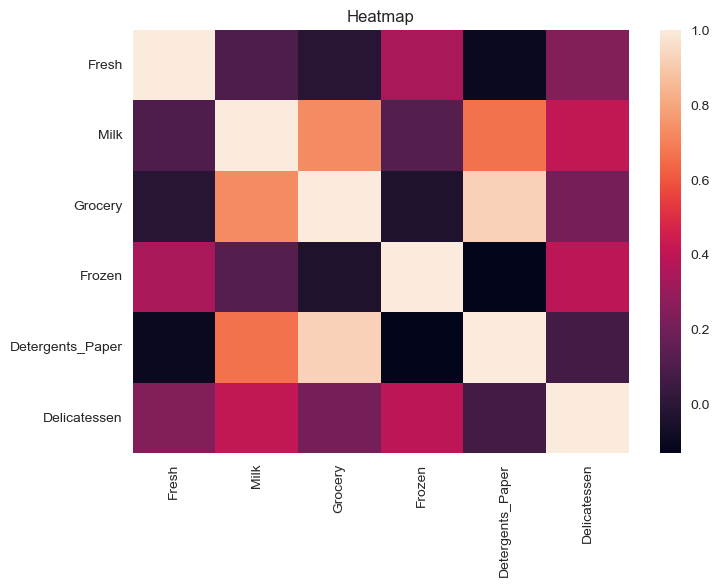

In [7]:
# Plot distributions of attributes: NUMERICAL (histograms, boxplot)
# Plot correlations (pairwise scatterplots and heatmap)
p1_functions.num_plot(df[num_features])

#### Observation:
The distributions are heavy tailed -> apply the log function to the continuous features so that the distribution becomes compressed for large values and expanded for small values

In [8]:
# Drop meta-data: Channel and the Region indicators
df = df.drop(columns=cat_features)

# Save the original dat set without meta-data
df_og = df.copy()
df_overview = df.copy() # we will use this to append the scores for an overview. Calculations are performed on df

# x ← log(x + 1)
df = np.log(df + 1)

### Recomputed plots

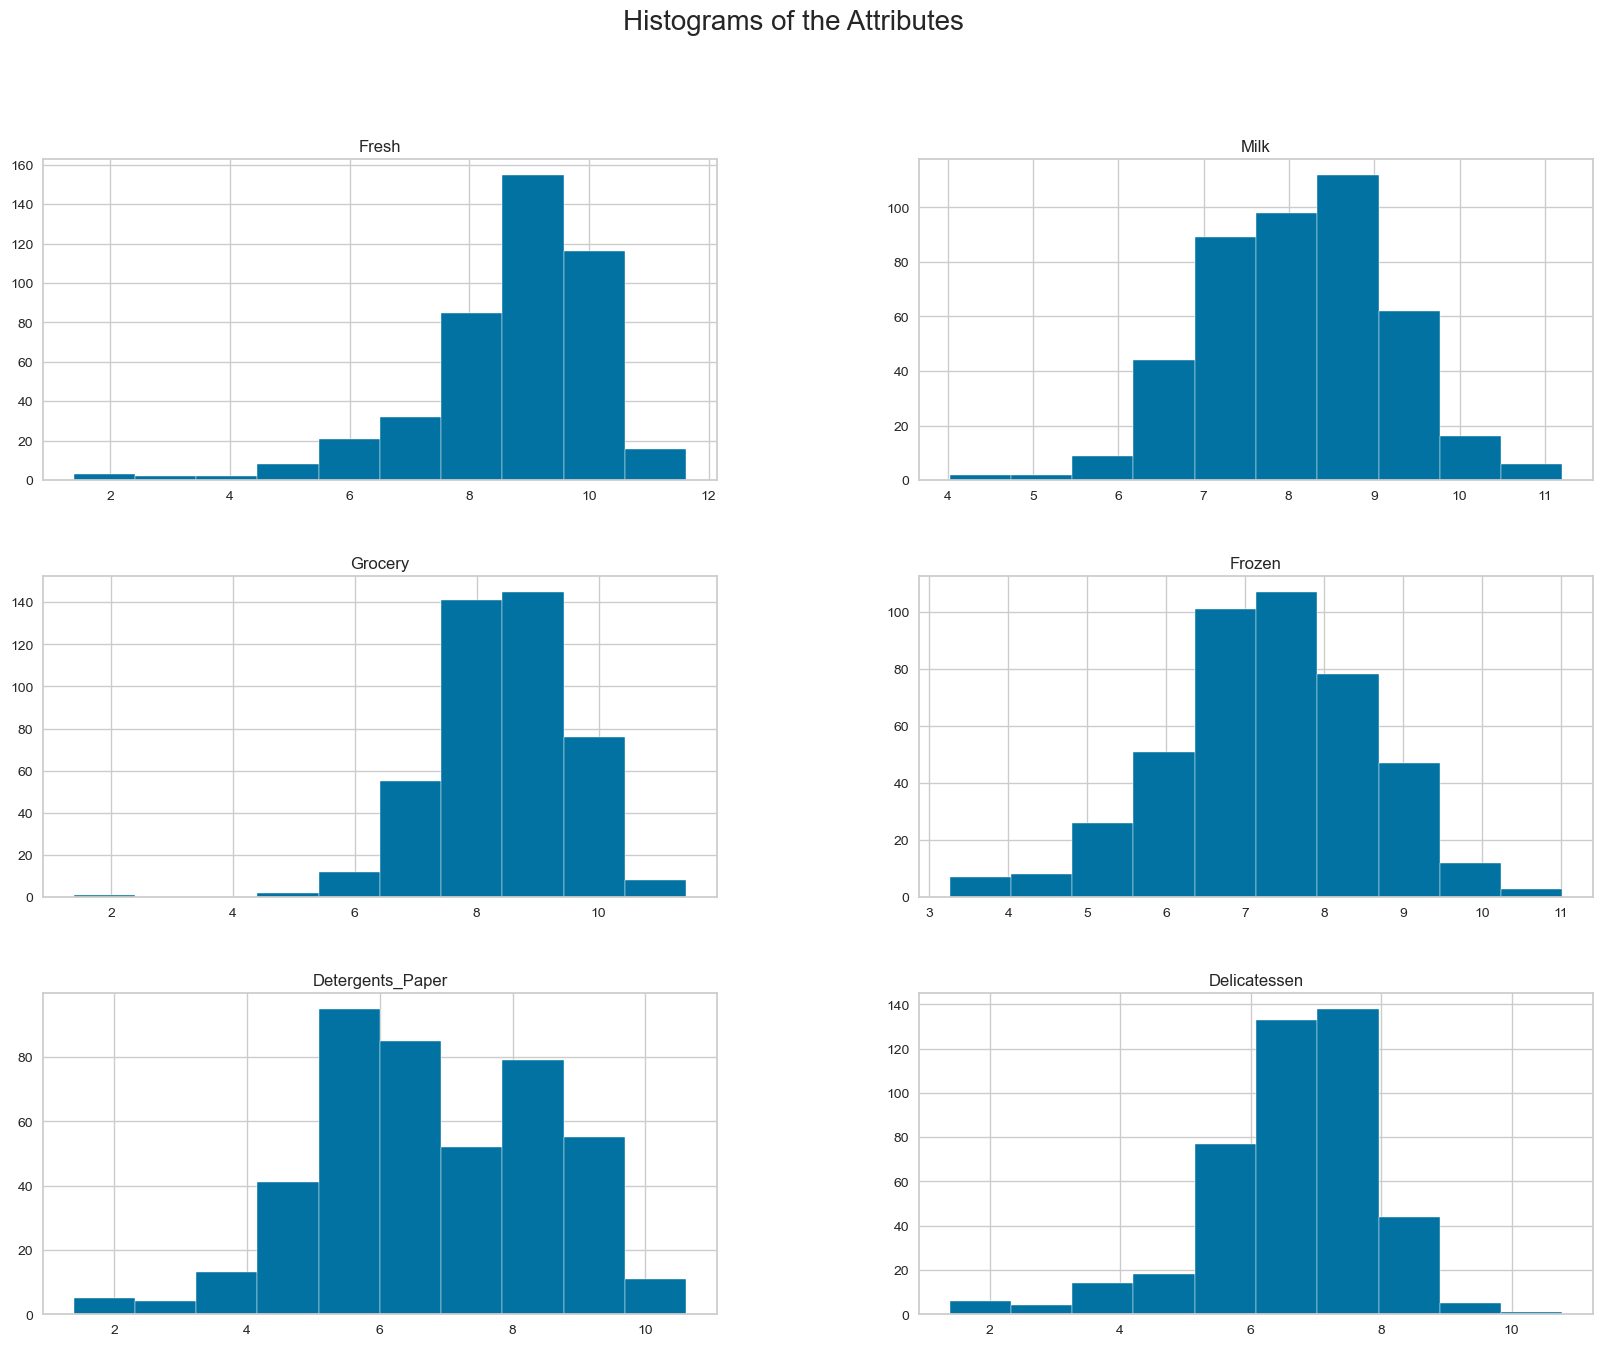

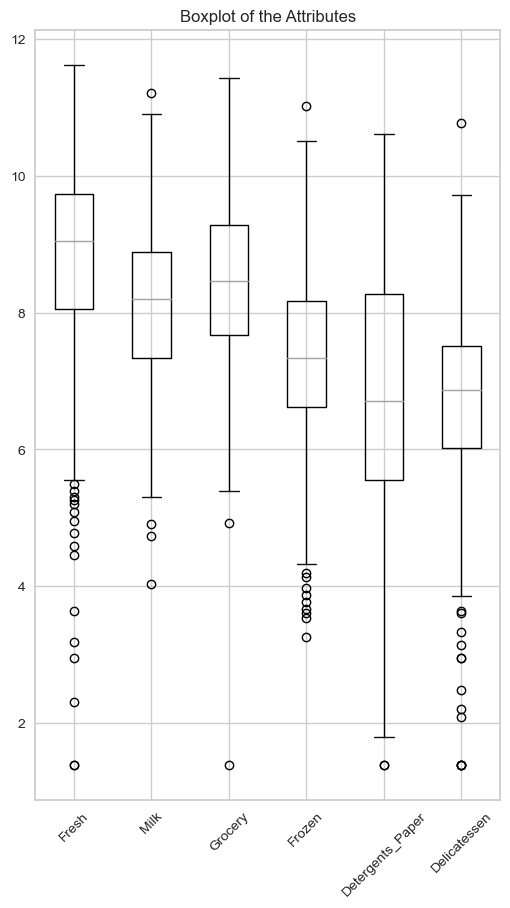

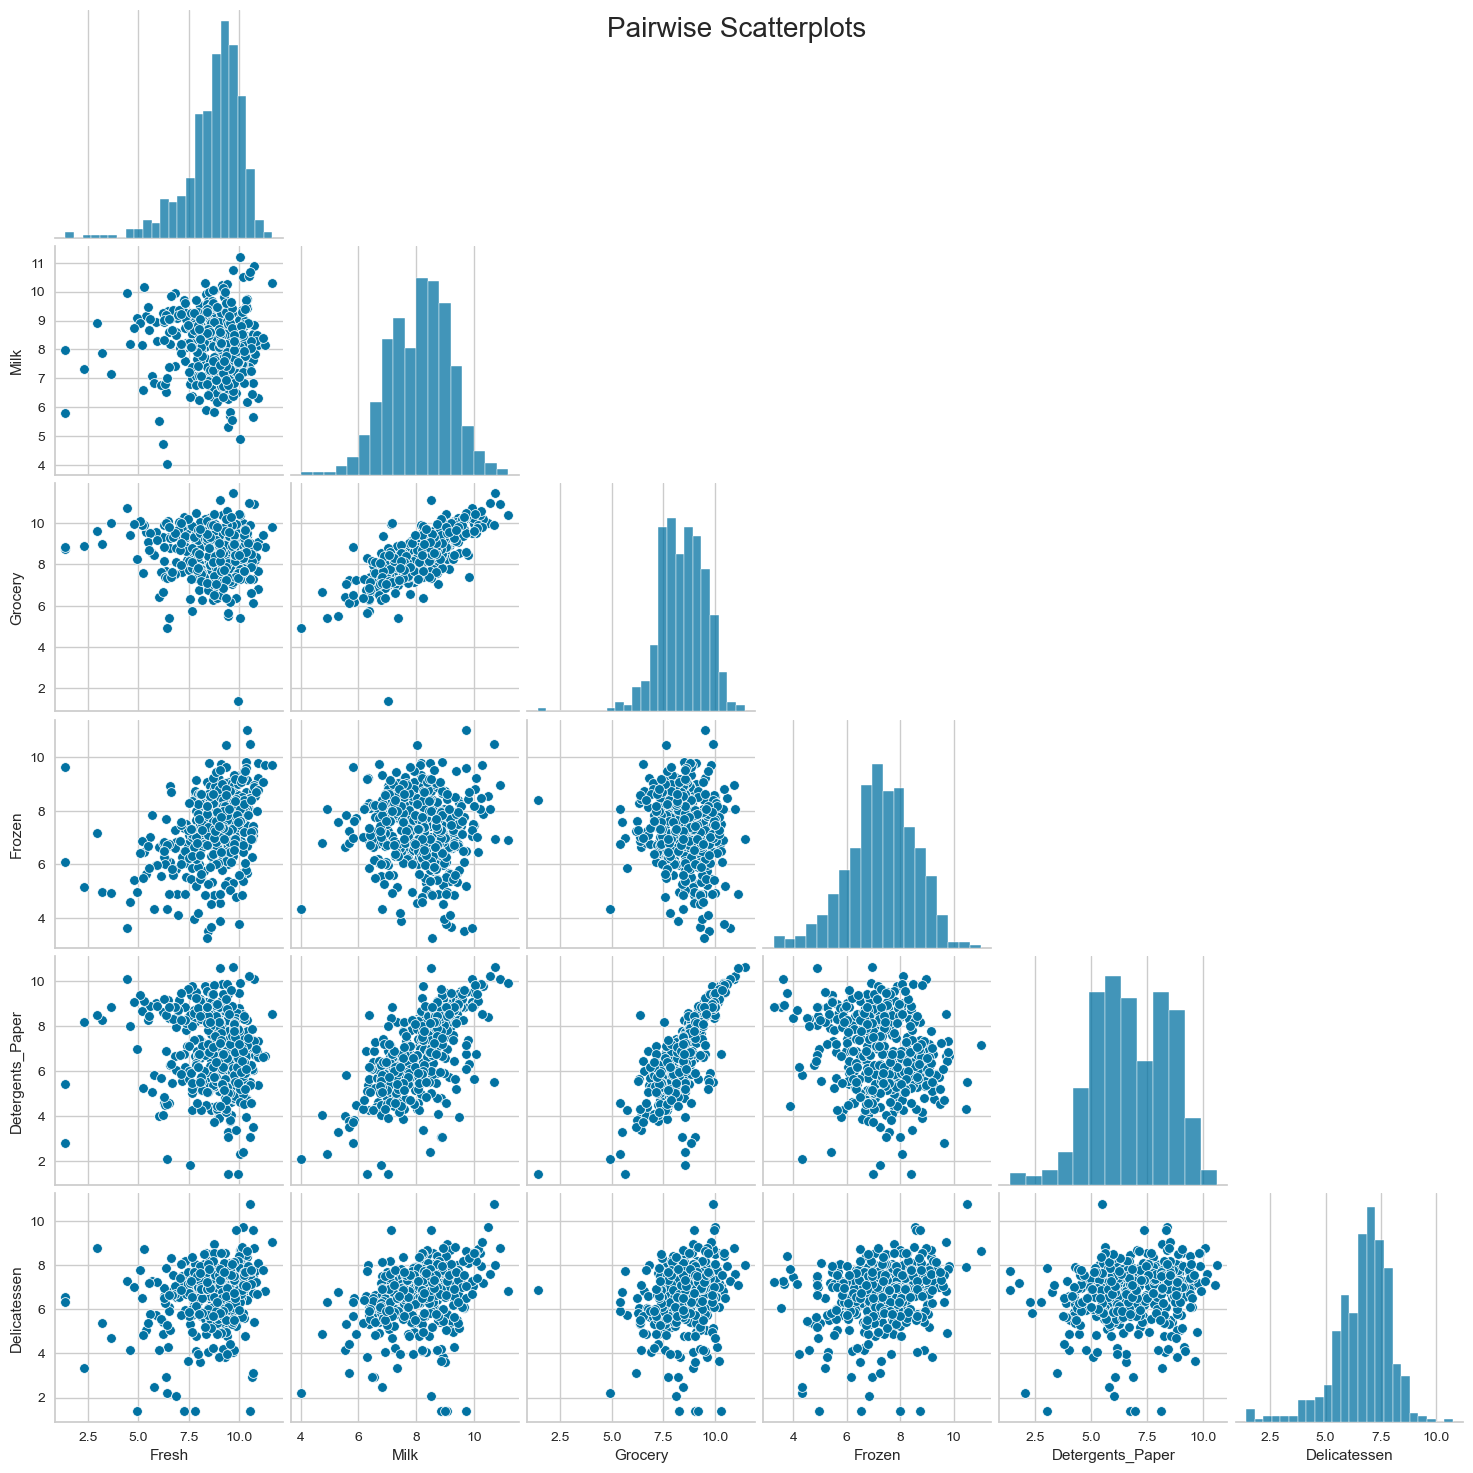

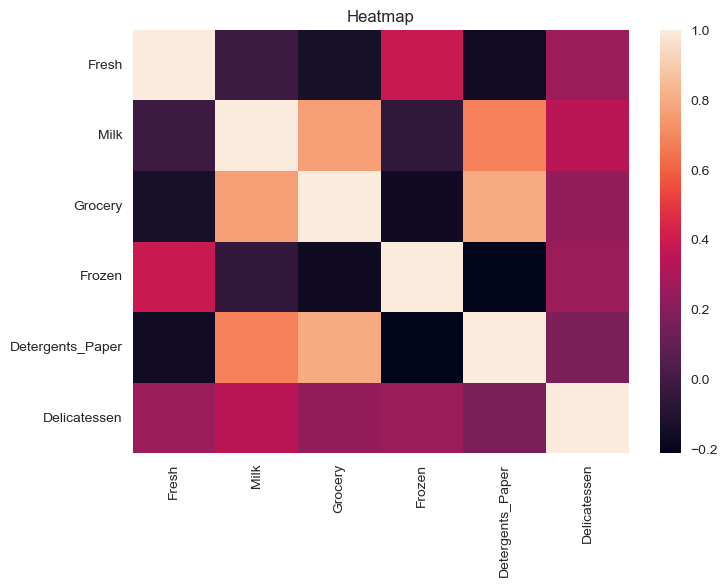

In [9]:
# Recompute plots after the transformation
p1_functions.num_plot(df)

#### Observation:
The log transformation produces more normally distributed attributes, however the statistics can not be reliably computed (e. g. correlations). Also, some lower values can now be considered extreme, while very few higher values still possess this quality (see boxplots).

# 2. Detecting Anomalies

## 2.1. Hard-Min Score

Compute the distance to the nearest neighbor for each instance. This measure is used as an outlier score. We assume that this measure is not very biased, but has a high variance. We therefore assume that using a bootstrap with the Hard-Min approach produces a more accurate and robust outlierness score. Later on, (together with some visual inspections) we evalute the accuracy of a more robust, but more biased estimator of the scores. Note that we are interested in the resulting ranking of the scores and not the scores per se.


### Fake it till you make it: Creating an artificial "Ground Truth"

In [10]:
# Setting the HYPERPARAMETERS
N_BOOTSTRAP = 1000
SAMPLE_SIZE_FRAC  = 0.5
OUTLIERS_FRAC = 0.04

The Spearman correlation as well as the scores increase with a higher sample size fraction (nearest neighbor distances increase monotonically since we consider fewer data points). To assess the bias of the soft Estimator, which we will consider later for different values of gamma, we classify the "OUTLIERS_FRAC" % of the most likely outliers from the hard-min bootstrap and check the accuracy.

The Sample size fraction is chosen in a way s.t. the spearman correlation with the Hard-Min on the whole dataset is high, but not too high.

The outliers frac of 4 % results in 14 samples from 440 in the dataset which seems a reasonable guess. This parameter can be adjusted given further domain knowledge or if an indicator is needed to make the outlier scores even more robust.

In [11]:
# Create Samples for Bootstrap approach
samples = [resample(df, n_samples=math.ceil(len(df) * SAMPLE_SIZE_FRAC), replace=False) for i in range(N_BOOTSTRAP)]

def hardmin_score(df):
    nbrs = NearestNeighbors(n_neighbors=2, algorithm="ball_tree").fit(df)
    distances, indices = nbrs.kneighbors(df)
    outlier_score_min = np.square(distances[:, 1])
    return outlier_score_min

def hardmin_bootstrap(n_bootstrap=N_BOOTSTRAP, sample_size_frac=SAMPLE_SIZE_FRAC, data=df, samples = samples):
        hard_min_scores_bootstrap = pd.DataFrame({i: np.full(N_BOOTSTRAP, np.nan) for i in range(len(df))})
        #samples = [resample(df, n_samples=math.ceil(len(df) * SAMPLE_SIZE_FRAC), replace=False) for i in range(N_BOOTSTRAP)]
        for i in range(0, N_BOOTSTRAP):
                sample = samples[i]
                hard_min_scores_bootstrap.loc[i, sample.index] = hardmin_score(sample)
                
        return hard_min_scores_bootstrap

Example for the bootstrap values table below:

In [12]:
hard_min_scores_bootstrap = hardmin_bootstrap(df)
display(hard_min_scores_bootstrap)

0         1         2         3         4         5         6    \
0    1.181445       NaN  1.302722  1.150950       NaN  0.571289  0.517339   
1         NaN  0.257170       NaN       NaN       NaN  0.571289       NaN   
2         NaN  0.257170  1.302722       NaN       NaN       NaN  1.016219   
3    1.181445  0.453793       NaN       NaN       NaN       NaN       NaN   
4         NaN       NaN       NaN       NaN  0.941192  0.984075       NaN   
..        ...       ...       ...       ...       ...       ...       ...   
995  1.181445       NaN  1.370179       NaN  0.941192       NaN       NaN   
996       NaN  0.267721       NaN  0.966356       NaN       NaN  0.517339   
997       NaN  0.257170       NaN       NaN  0.833497       NaN       NaN   
998  1.777377  0.267721  1.370179       NaN       NaN       NaN  0.517339   
999  1.181445       NaN  1.302722       NaN  0.833497  0.984075  0.556249   

          7         8         9    ...       430       431       432  \
0    0.153060       NaN  0.790723  ...  3.446799  1.523458       NaN   
1    0.153060       NaN       NaN  ...       NaN  0.574922       NaN   
2    0.432329  1.016219       NaN  ...       NaN       NaN  0.402235   
3    0.581234       NaN  0.807819  ...       NaN  0.574922       NaN   
4         NaN       NaN       NaN  ...       NaN  1.523458  0.402235   
..        ...       ...       ...  ...       ...       ...       ...   
995  0.153060  0.909097       NaN  ...  3.446799       NaN       NaN   
996       NaN       NaN  0.353179  ...  4.442495       NaN       NaN   
997       NaN  1.177624       NaN  ...  3.446799       NaN       NaN   
998  0.153060  0.909097       NaN  ...       NaN  0.574922  0.402235   
999  0.153060  0.941408  0.353179  ...  3.446799  0.574922       NaN   

          433       434       435       436       437       438       439  
0    0.898605  0.556249       NaN       NaN       NaN  0.781667       NaN  
1    1.081425       NaN       NaN  1.742683  0.966305       NaN       NaN  
2    1.081425       NaN       NaN       NaN       NaN       NaN  5.641165  
3    0.898605  1.137104       NaN       NaN  0.966305  0.781245  6.237760  
4    1.081425  0.926908       NaN  2.315472  0.966305  1.601980  5.641165  
..        ...       ...       ...       ...       ...       ...       ...  
995  0.898605       NaN  2.476255       NaN       NaN       NaN       NaN  
996       NaN  0.556249       NaN  1.742683  0.966305       NaN  6.237760  
997  1.081425       NaN  2.680879       NaN       NaN  0.809482  6.107358  
998       NaN       NaN  2.476255       NaN  1.532779  0.781245  5.641165  
999       NaN  0.556249  2.952920       NaN       NaN       NaN       NaN  

[1000 rows x 440 columns]

We save the Hard-Min outlier scores for the whole dataset as well as the mean outlier scores over the bootstrap samples without replacement. We than compare the two.

In [13]:
df_overview["hardmin_score"] = hardmin_score(df)
df_overview["hardmin_bootstrap_score"] = hardmin_bootstrap(data=df).mean()
#display(df_overview.head())
df_overview.sort_values(by="hardmin_bootstrap_score", ascending=False).head(10)

Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicatessen  \
338      3    333     7021   15601                15           550   
75   20398   1137        3    4407                 3           975   
154    622     55      137      75                 7             8   
142  37036   7152     8253    2995                20             3   
95       3   2920     6252     440               223           709   
183  36847  43950    20170   36534               239         47943   
187   2438   8002     9819    6269              3459             3   
128    140   8847     3823     142              1062             3   
204   1956    891     5226    1383                 5          1328   
109   1406  16729    28986     673               836             3   

     hardmin_score  hardmin_bootstrap_score  
338      24.462058                30.418908  
75       21.598732                23.424311  
154      17.656426                21.374615  
142      14.249027                17.422287  
95       14.033121                17.142703  
183       8.742070                10.147402  
187       9.006401                10.097105  
128       8.841779                 9.890088  
204       8.531557                 8.965766  
109       7.406475                 8.413036

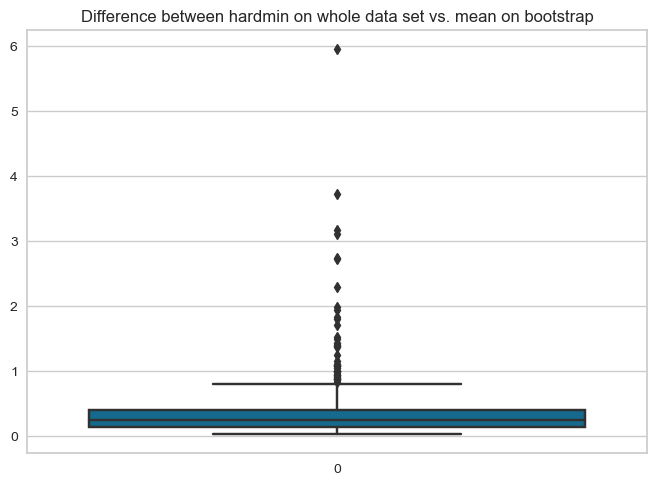

In [14]:
# Check difference! Stabilized it a little bit
sns.boxplot(np.abs(df_overview["hardmin_bootstrap_score"] - df_overview["hardmin_score"])).set_title("Difference between hardmin on whole data set vs. mean on bootstrap")
plt.show()

### Everything gets down to choosing the right evaluation metric

Compare Hard-Min and Hard-Min-bootstrap appraoches by statistical means as well as "artificial" outlier classification.

Later when we will try to choose an optimal gamma, we will use the same approach!

In [15]:
def score_bias_eval(scores, baseline=df_overview["hardmin_bootstrap_score"].to_numpy(), outlier_frac=OUTLIERS_FRAC,
                    return_p_val=False):
    n_outliers = math.ceil(len(baseline) * outlier_frac)
    spr = spearmanr(scores, baseline)
    hardmin_bootstrap_ranking = np.argsort(baseline * (-1))
    hardmin_outliers = hardmin_bootstrap_ranking[:n_outliers]
    score_outlier_ranking = np.argsort(scores * (-1))
    score_outliers = score_outlier_ranking[:n_outliers]

    accuracy = len(set(hardmin_outliers).intersection(score_outliers)) / n_outliers

    return spr[0], accuracy

spr, acc = score_bias_eval(scores=df_overview["hardmin_score"])

print(f"Bootstrap Accuracy: {acc:.2}% \nSpearman results: {spr}")

Bootstrap Accuracy: 0.89% 
Spearman results: 0.9477731224872366


## 2.2. The Soft-Min Score/KDE approach

To get a better understanding what we'll do next, we will compute the soft-min scores for a fixed Gamma value and compare them to our baseline/ground-truth.

In [16]:
GAMMA = 1

In [17]:
nbrs = NearestNeighbors(n_neighbors=len(df), algorithm="ball_tree").fit(df)
distances, indices = nbrs.kneighbors(df)
distances = np.square(distances)

def softmin(z, gamma=GAMMA):
    return (-1 / gamma) * np.log( (1 / (len(z) - 1)) * np.sum(np.exp(-gamma * z)) )


df_overview["outlier_score_softmin"] = np.apply_along_axis(softmin, 1, distances[:, 1:], GAMMA)
spr, acc = score_bias_eval(scores=df_overview["outlier_score_softmin"])

print(f"Bootstrap Accuracy: {acc:.2}% \nSpearman results: {spr}")

Bootstrap Accuracy: 0.89% 
Spearman results: 0.9290718068134274


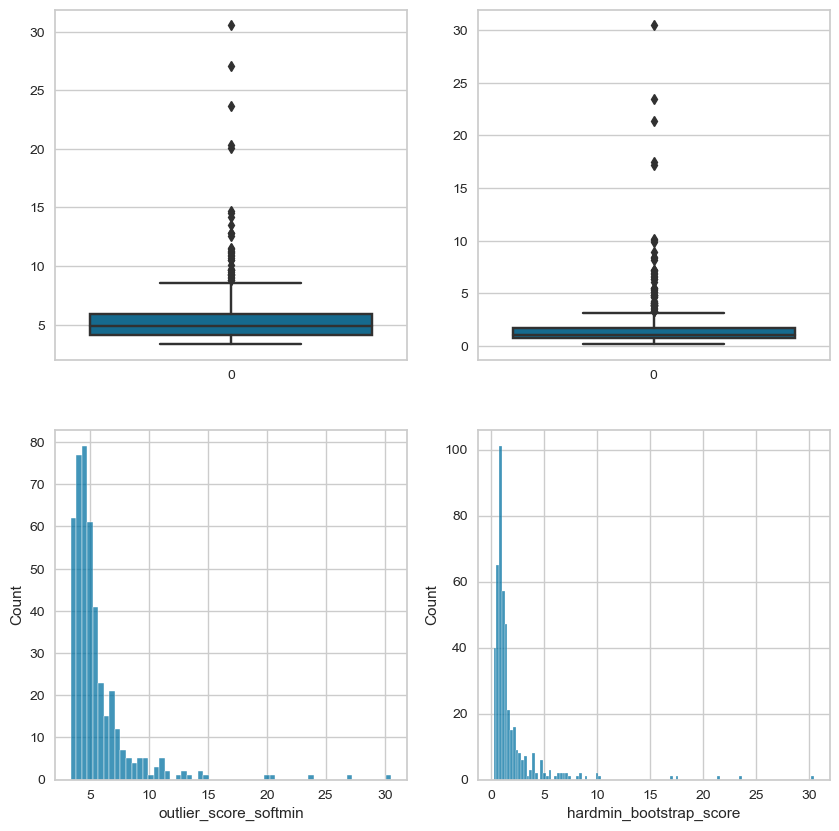

In [18]:
# Visually compare distributions of the scores
fig, axs = plt.subplots(2,2, figsize=(10,10))

sns.boxplot(df_overview["outlier_score_softmin"], ax=axs[0, 0])
sns.histplot(df_overview["outlier_score_softmin"], ax=axs[1, 0])
sns.boxplot(df_overview["hardmin_bootstrap_score"], ax=axs[0, 1])
sns.histplot(df_overview["hardmin_bootstrap_score"], ax=axs[1, 1])
plt.show()

We can see that the distributions are quite similar although they "operate" on different scales. When we thought about how to evaluate different measures, first we tried to use the variance of the outlier scores as a possible measure for the signal power of the respective score. But the Soft-Min function operates on different scales for different values of gamma which makes a comparison hard. Just because a different scale/variance is used, this does not have to implicate that the score is better or worse. Instead, we are interested in the resulting ranking. That's why we will focus on the spearman rank correlation as well as our "artificial" accuracy specified above in the Hard-Min bootstrap case.

Note that we tried different approaches, e.g. leaving the factor of 1/gamma out of the Soft-Min function to get comparable scales. We will also introduce some visual inspections. For example, in the following we can see how the Soft-Min score for a given instance changes for different values of gamma. We will use this for each instance to evaluate the development of the scores.

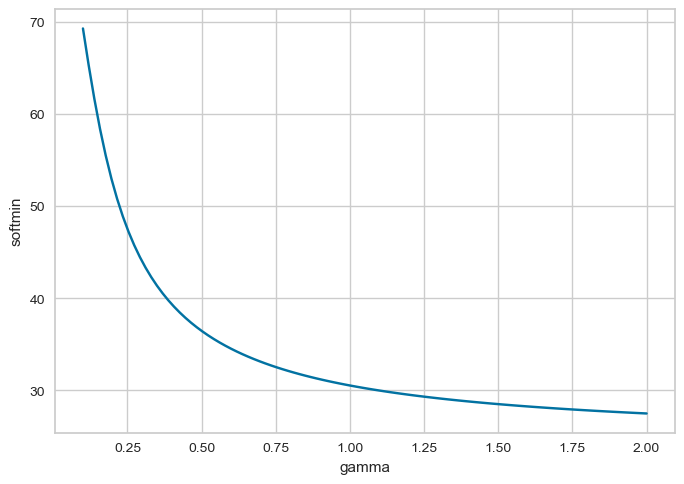

In [19]:
# 338 has had a high outlier score
instance = 338
gammas = np.linspace(0.1, 2, 100)
g = sns.lineplot(
    x=gammas, y=[softmin(distances[instance, 1:], gamma) for gamma in gammas]
)
g.set_xlabel("gamma")
g.set_ylabel("softmin") 
plt.show()

We can clearly see how the scale of the Soft-Min score changes!

## 2.3. Bootstrap/Robustness evaluation & the curse of choosing a bandwidth

Since the Soft-Min score can be interpreted as a KDE-approach, the chosen gamma corresponds to the inverse of the bandwidth or variance of the used Gaussian distributions. Because of that, a high gamma leads to less biased estimates but with the cost of introducing a higher estimator variance! It is known that finding an appropriate bandwidth is a crucial and non-trivial task (and also way more important than choosing a kernel).

Consequently, if we want to choose gamma, we have to evaluate the bias and variance of our estimator. To do this, we will use the bootstrap approach without resampling on a fraction size of the whole dataset. This will be set as a Hyperparameter and has to be chosen in a way that the data is varying enough but still carries enough information/is representative for the whole dataset. To evaluate the model variance for a given gamma, we will compute the score for each instance for each bootstrap round, then compute the within-variance of each sample across the different bootstrap rounds and finally aggregate the variances for each sample with a mean across the whole dataset.

To analyse the bias, we will use the approaches discussed above.

In [20]:
N_BOOTSTRAP = 100
gamma_range = np.linspace(0.1, 2, 20)

In [21]:
def softmin(z, gamma):
    return - (1/gamma)  * np.log(1 / (len(z) - 1) * np.sum(np.exp(-gamma * z)))

In [22]:
scores = np.full((len(df), N_BOOTSTRAP, len(gamma_range)), np.nan) # customer x bootstrap round x gamma

for i in range(0, N_BOOTSTRAP):

    sample = samples[i]

    nbrs = NearestNeighbors(n_neighbors=len(sample), algorithm="ball_tree").fit(sample)
    distances, indices = nbrs.kneighbors(sample)
    distances = np.square(distances[:, 1:])
    
    for j, gamma in enumerate(gamma_range):
        scores[sample.index, i, j] = np.apply_along_axis(softmin, 1, distances, gamma)

In [23]:
# verify normal distribution arround N_BOOTSTRAP * frac
# sns.histplot(np.sum(np.isnan(scores) == False, axis=1)[:,0]).set_xlabel("# not sampled")
# plt.show()

In [24]:
np.nanmean(scores, axis=1).shape

(440, 20)

(440, 20)

average outlier score of instance 0:


array([12.87584883, 10.57947486,  9.11033581,  8.08209698,  7.31647667,
        6.71863789,  6.23495577,  5.83327177,  5.49312735,  5.20078123,
        4.94656183,  4.72339164,  4.52592368,  4.35001224,  4.19237454,
        4.05036628,  3.92182744,  3.80497323,  3.69831474,  3.60059978])

average outlier score of instance 338:


array([69.53391372, 54.35319106, 46.9324699 , 42.91727639, 40.43998163,
       38.76483752, 37.5573537 , 36.64576158, 35.93317008, 35.36082531,
       34.89102801, 34.49847503, 34.16555058, 33.87961358, 33.63135832,
       33.41378334, 33.22152041, 33.05038498, 32.89706719, 32.75891485])

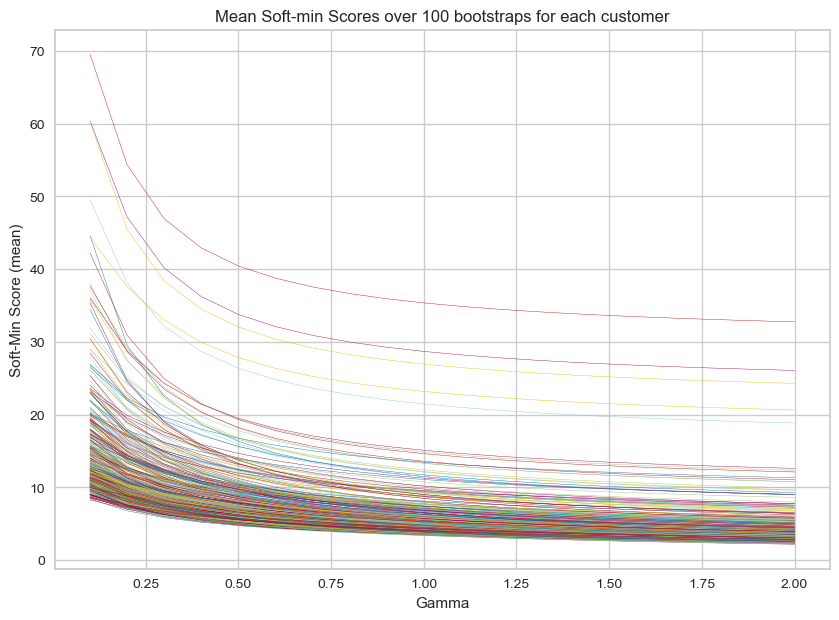

In [25]:
# average outlier score per sample, per gamma
avg_score = np.nanmean(scores, axis=1)

display(avg_score.shape)
print("average outlier score of instance 0:")
display(avg_score[0])

print("average outlier score of instance 338:")
display(avg_score[338])


fig = plt.figure(figsize=(10,7))
for i in range(len(scores)):
    plt.plot(gamma_range, avg_score[i], linewidth=0.3)
    plt.xlabel("Gamma")
    plt.ylabel("Soft-Min Score (mean)")
    plt.title(f"Mean Soft-min Scores over {N_BOOTSTRAP} bootstraps for each customer")
plt.show()

While the Soft-Min Scores are getting lower for all the samples for increasing gammas, the ranking more or less stays the same! Especially the ones with the highest scores are still just as separable. Hence, we discarded the variance over the scores as a potential measure of bias.

(440, 20)

Vars of instance 0:


array([0.17065527, 0.12673896, 0.10607989, 0.09290043, 0.08358817,
       0.07672112, 0.07147955, 0.06730836, 0.06382539, 0.06078136,
       0.05802762, 0.05548515, 0.05311783, 0.05091226, 0.0488648 ,
       0.0469741 , 0.04523765, 0.04365066, 0.0422061 , 0.04089526])

Vars of instance 338:


array([ 6.17439541, 23.95696815, 33.41651839, 38.09774316, 40.84359107,
       42.63272753, 43.87722616, 44.782357  , 45.46254444, 45.98678776,
       46.3991529 , 46.72903433, 46.99672238, 47.21661839, 47.39918509,
       47.55217745, 47.6814447 , 47.79146733, 47.885725  , 47.96695372])

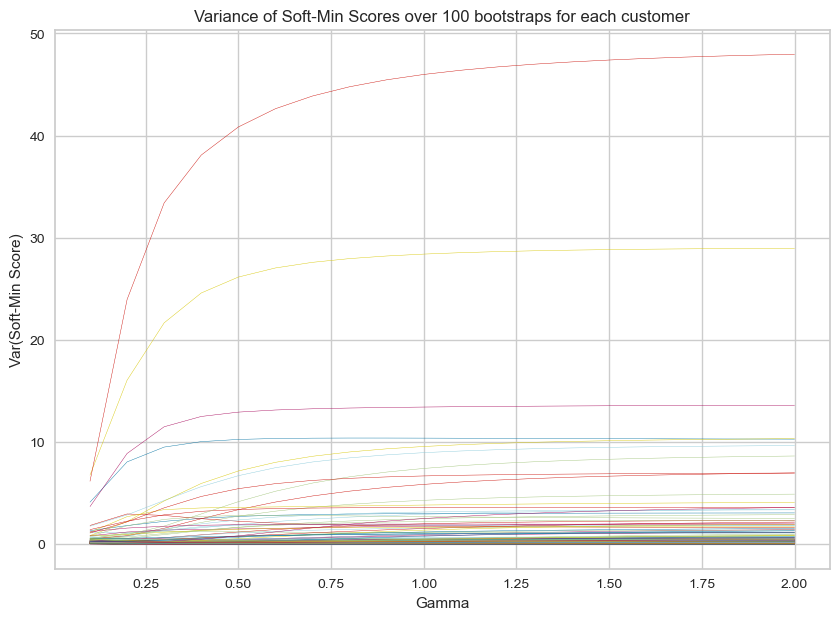

In [26]:
# calculate the spread over bootstrap dimension aka within sample variance
spread = np.nanvar(scores, axis=1)

# Comparing inlier vs outlier
display(spread.shape)
print("Vars of instance 0:")
display(spread[0])

print("Vars of instance 338:")
display(spread[338])


# all spreads per instances
fig = plt.figure(figsize=(10,7))
for i in range(len(scores)):
    plt.plot(gamma_range, spread[i], linewidth=0.3)
    plt.xlabel("Gamma")
    plt.ylabel("Var(Soft-Min Score)")
    plt.title(f"Variance of Soft-Min Scores over {N_BOOTSTRAP} bootstraps for each customer")
plt.show()


We can see that the variance of the model increases with increasing gamma just as expected. What strikes out is that it increases way more for outliers than for inliers. Since our purpose is to detect outliers, we have to carefully choose our gamma value to have robust estimates.

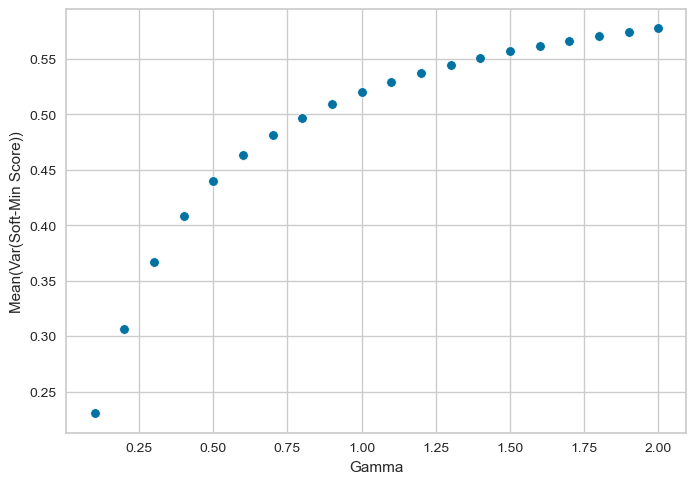

In [27]:
# Check mean behaviour as well
g = sns.scatterplot(x=gamma_range, y=np.mean(np.nanvar(scores, axis=1), axis=0))
g.set_xlabel('Gamma')
g.set_ylabel('Mean(Var(Soft-Min Score))')
plt.show()

Although the variance is way higher for the outliers, the mean reflects the model variance on a low scale as well. Nevertheless, we will use the mean of the variances of the most anomalous datapoints to make sure that the model variance is low in the area of interest. But as we have seen, this should not affect the results in a considerable way, since the variance increases in the mean as well!

In [28]:
#print(avg_score.shape)
spr, acc = score_bias_eval(scores=avg_score[:, 1])
print(f"Bootstrap Accuracy: {acc:.2}% \nSpearman results: {spr}")

Bootstrap Accuracy: 0.83% 
Spearman results: 0.7699056015033886


In [29]:
def mean_var_of_most_anomalous(customer_variances, n_most_outliers_considerd = OUTLIERS_FRAC):
    n_most_outliers_considerd = math.ceil(len(customer_variances) * OUTLIERS_FRAC)
    var_of_outliers = np.sort(customer_variances)[::-1][:n_most_outliers_considerd]
    return np.mean(var_of_outliers)


In [30]:
bias_measures = np.apply_along_axis(score_bias_eval, 0, avg_score)
var_measures = np.apply_along_axis(mean_var_of_most_anomalous, 0, spread)
gamma_overview = pd.DataFrame(bias_measures, index=["Spearman Corr", "Accuracy"])
gamma_overview.loc["Model Var", :] = var_measures
gamma_overview

0         1         2         3         4         5   \
Spearman Corr  0.705052  0.769906  0.813483  0.843863  0.867404  0.883636   
Accuracy       0.833333  0.833333  0.888889  0.888889  0.944444  0.944444   
Model Var      2.029637  4.604428  6.192471  7.182847  7.828743  8.275507   

                     6         7         8         9         10        11  \
Spearman Corr  0.897455  0.908103  0.917112  0.925033  0.931688  0.938192   
Accuracy       0.944444  0.944444  0.944444  0.944444  0.888889  0.888889   
Model Var      8.602016  8.848239  9.035660  9.184847  9.300734  9.392145   

                     12        13        14        15        16        17  \
Spearman Corr  0.943371  0.948630  0.953053  0.956685  0.960181  0.963218   
Accuracy       0.888889  0.888889  0.944444  0.944444  0.888889  0.888889   
Model Var      9.465262  9.524484  9.573000  9.613152  9.646690  9.674939   

                     18        19  
Spearman Corr  0.966038  0.968723  
Accuracy       0.888889  0.944444  
Model Var      9.698914  9.719403

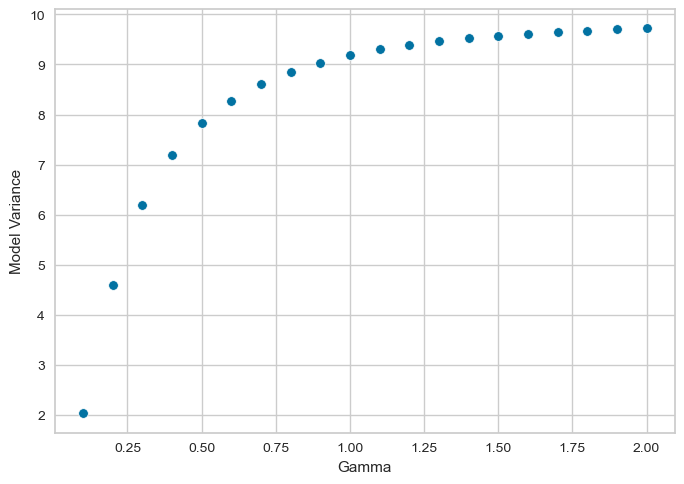

In [31]:
g = sns.scatterplot(x=gamma_range, y=var_measures)
g.set_xlabel('Gamma')
g.set_ylabel('Model Variance')
plt.show()

## 2.4. Gamma selection

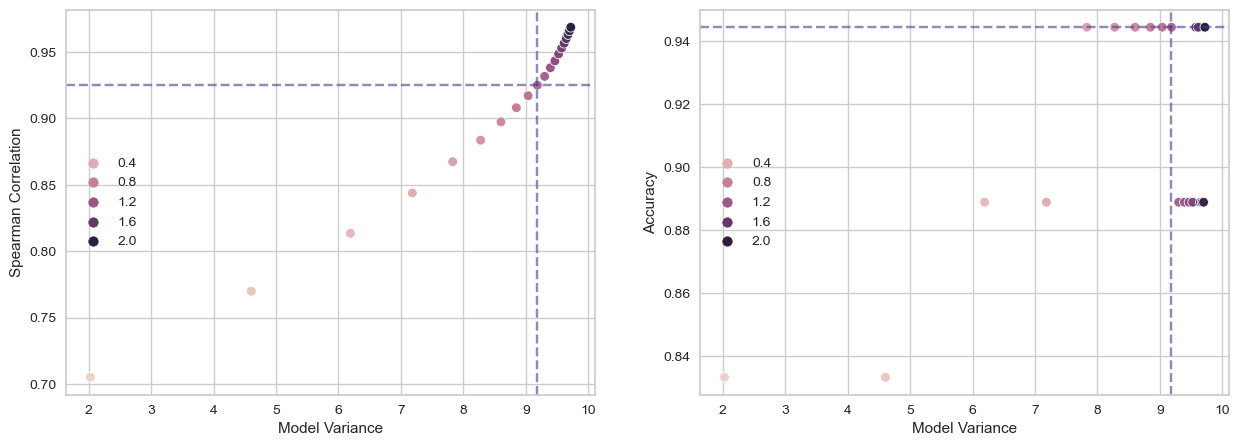

In [32]:
# Add lines for gamma = 1
filter = np.around(gamma_range, 1) == 1
acc = gamma_overview.loc["Accuracy"][filter]
sc = gamma_overview.loc["Spearman Corr"][filter]
var = gamma_overview.loc["Model Var"][filter]

figure, axs = plt.subplots(1,2, figsize=(15, 5))

g = sns.scatterplot(y=gamma_overview.loc["Spearman Corr", ], x=gamma_overview.loc["Model Var", ], hue=gamma_range, ax=axs[0])
g.axhline(y=sc.values, linestyle ="--", color="darkslateblue", alpha=0.6)
g.axvline(x=var.values, linestyle ="--", color="darkslateblue", alpha=0.6)
g.set_xlabel('Model Variance')
g.set_ylabel('Spearman Correlation')

g = sns.scatterplot(y=gamma_overview.loc["Accuracy", ], x=gamma_overview.loc["Model Var", ], hue=gamma_range, ax=axs[1])
g.axhline(y=acc.values, linestyle ="--", color="darkslateblue", alpha=0.6)
g.axvline(x=var.values, linestyle ="--", color="darkslateblue", alpha=0.6)
g.set_xlabel('Model Variance')
g.set_ylabel('Accuracy')

plt.show()

Note: The Spearman correlation could also be restricted on the most probable outliers just like in the case of the model variance. But since we also use the “artificial” accuracy, we can see that the Score is apropiate even in the “crucial” area of interest.

Interpretation:

In the first plot we can see that the Spearman correlation increases with higher gamma - this would call for higher gamma values, but the stability of the score simultaneously decreases as measured by model variance.

In the second plot it is visible that the ability of the Soft-Min measure to correctly classify the 4 % of the most anomalous scores is increasing with increasing gamma values up to some point. For approximately gamma = 0.5 the accuracy reaches its maximum and for gamma > 1 it becomes unstable which can be explained by the high model variance.

This would imply that the gamma should be in the range of 0.5 to 1.
Even though the accuracy is not changing, the Spearman correlation measure increases in this range, therefore we can set gamma to 1 in order to achieve the best trade-off between bias and robustness.

## 2.5. Outlier selection

With the chosen gamma we can define the outliers of the data set. First, we plot the outlier scores for each data point.

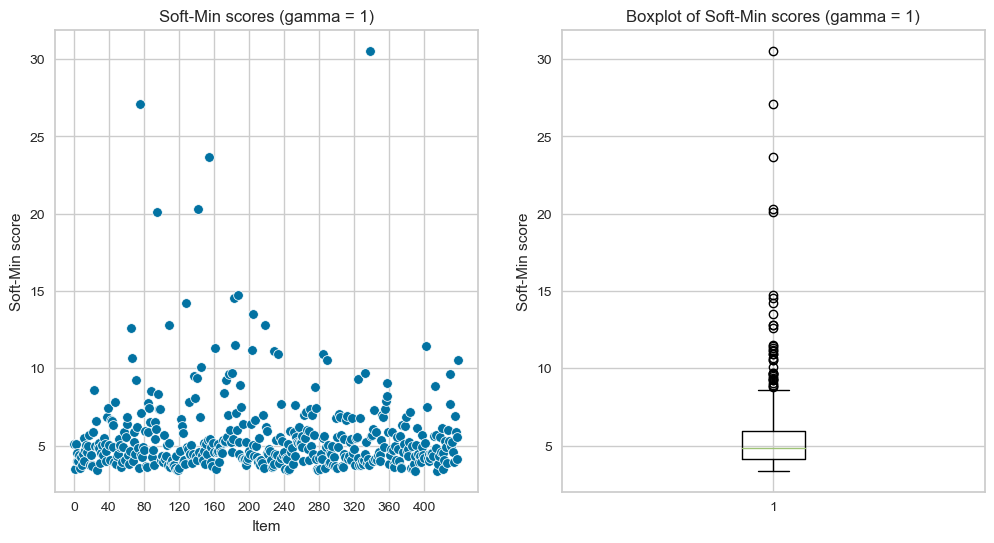

In [33]:
# The scores are already computed for gamma = 1
outliers = df_overview["outlier_score_softmin"]

min, max = p1_functions.plot_outliers(outliers)

We can see how many points are calculated as outliers for the
* points with a score above 15 (visually most extreme)
* points with a score above 10 (visually another potential barrier)
* outlier values of the boxplot

In [34]:
for n in (15, 10, max):
    mask = outliers > n
    outliers_selected = outliers.argsort()[::-1][:sum(mask)]
    print(outliers_selected.shape[0], "outliers above", str(n))

5 outliers above 15
23 outliers above 10
36 outliers above 8.562896858520753


We chose to define the 5 points with anomaly score above 15 as outliers since they represent 4 % of the data and do not want to remove too many points without prior knowledge of the customer base represented by the data set.

In [35]:
mask = outliers > 15
outliers_selected = outliers.argsort()[::-1][:sum(mask)]

# Display the spending of the outlier customers in the original data set
df_og.iloc[outliers_selected,:]

Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
338      3   333     7021   15601                15           550
75   20398  1137        3    4407                 3           975
154    622    55      137      75                 7             8
142  37036  7152     8253    2995                20             3
95       3  2920     6252     440               223           709

# 3. Explaining Anomalies

## 3.1. Layer-wise relevance propagation

In [36]:
def relevance(x, yj, gamma):
    """Calculate layer-wise relevance propagation
    @x: array of instances
    @yj: softmin scores of all j instances
    @gamma: gamma used for softmin 
    """

    Rji = np.zeros(x.shape)

    # calculation per instance
    for j in range(len(x)):

        # mask is used to exclude the current instance j
        mask = np.full((len(x)), True)
        mask[j] = False

        # save xk - xj
        xk_j = x - x[j]

        # calculate zk = ||xj - xk||^2
        zk = np.square(np.linalg.norm(xk_j, axis=1))

        # 1. First, one identifies to what extent each data point has contributed to the anomaly score of instance j
        temp = np.exp(-gamma * zk[mask])
        Rk = temp / np.sum(temp) * yj[j]

        # 2. Then, these scores can be propagated back to the input features by observing that the (squared)
        # Euclidean distance entering the anomaly score can be decomposed in terms of individual components:
        Rji[j, :] = np.sum(np.square(xk_j)[mask] / zk[mask][:, None] * Rk[:, None], axis=0)

    return Rji


In [37]:
GAMMA = 1

# Calculate anomaly scores
nbrs = NearestNeighbors(n_neighbors=len(df), algorithm="ball_tree").fit(df)
distances, _ = nbrs.kneighbors(df)
yj = np.apply_along_axis(softmin, 1, np.square(distances[:, 1:]), GAMMA)

x = df.to_numpy()
Rji = relevance(x, yj, gamma)

# confirm conservation property
np.all(np.sum(Rji, axis=1) - yj <= 1e-14)

True

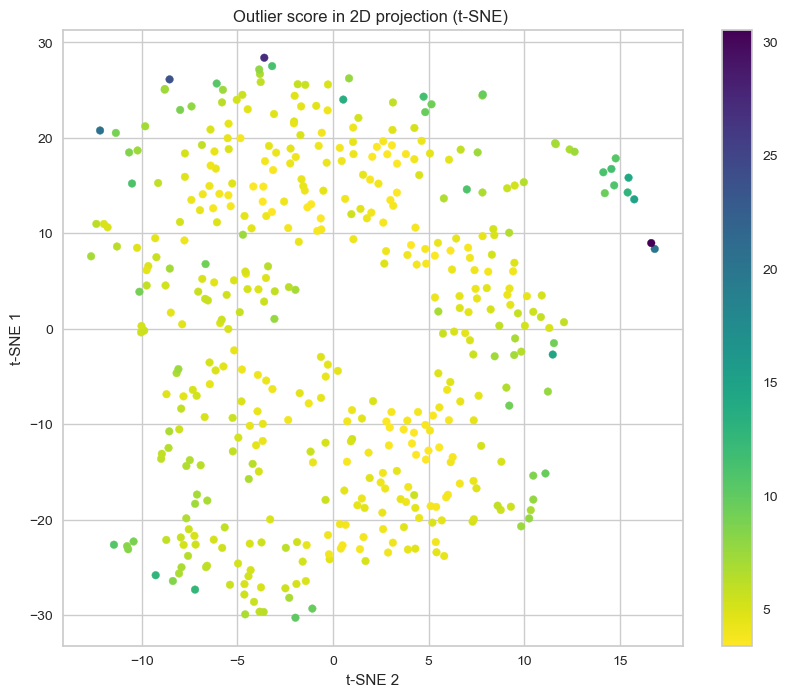

In [38]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30).fit_transform(df)

f, ax = plt.subplots(figsize=(10,8))
points = ax.scatter(x=X_embedded[:,1], y=X_embedded[:,0], c=yj, s=30, cmap=plt.colormaps.get_cmap('viridis_r'))
f.colorbar(points)
ax.set_ylabel("t-SNE 1")
ax.set_xlabel("t-SNE 2")
ax.set_title("Outlier score in 2D projection (t-SNE) ")
plt.show()

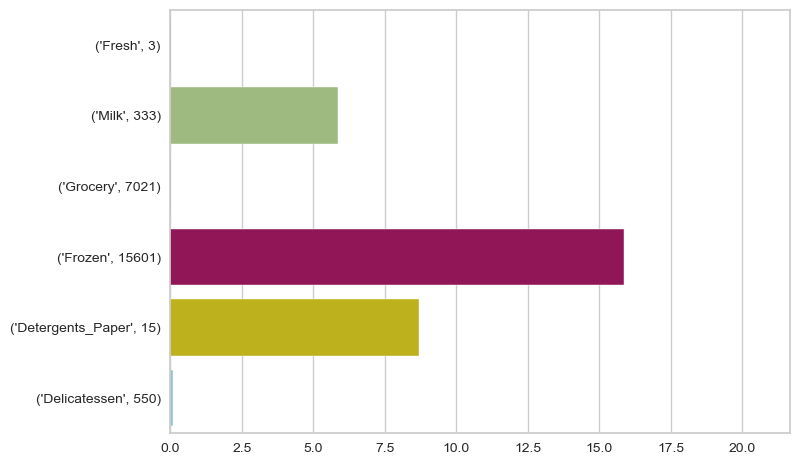

Ri: [1.00643561e-03 5.87019299e+00 1.67976699e-02 1.58746810e+01
 8.69405533e+00 8.02872022e-02]
Outlier score: 30.537020599125505


Fresh               1.386294
Milk                5.811141
Grocery             8.856803
Frozen              9.655154
Detergents_Paper    2.772589
Delicatessen        6.311735
Name: 338, dtype: float64

Fresh        Milk     Grocery      Frozen  Detergents_Paper  \
count  440.000000  440.000000  440.000000  440.000000        440.000000   
mean     8.732813    8.121615    8.442205    7.303128          6.791781   
std      1.470618    1.080635    1.111523    1.281888          1.709519   
min      1.386294    4.025352    1.386294    3.258097          1.386294   
25%      8.048378    7.335633    7.675081    6.611024          5.551989   
50%      9.048404    8.196435    8.467267    7.331043          6.706242   
75%      9.737123    8.880619    9.273948    8.176177          8.274596   
max     11.627610   11.205027   11.437997   11.016496         10.617123   

       Delicatessen  
count    440.000000  
mean       6.671094  
std        1.293960  
min        1.386294  
25%        6.014321  
50%        6.873680  
75%        7.507278  
max       10.777789

In [39]:
instance = 338
g = sns.barplot(x=Rji[instance], y=list(map(str, list(zip(df_og.iloc[instance].index, df_og.iloc[instance].values)))))
g.set_xlim(0,np.max(Rji))
plt.show()

print("Ri:", Rji[instance])
print("Outlier score:", yj[instance])
display(df.iloc[instance])
display(df.describe())

## 3.2. Reproducibility experiment for the explanations of the anomalies

### 3.2.1. Inspection of gamma influence on the robustness of anomaly attribution scores

First, we perform a similar experiment as in Part 2.
For 100 bootstrap samples (n = 220) without replacement we compute the Soft-Min scores for 20 gamma values in the range [0.1, 2] and calculate the attribution to the outlierness of each feature.

In [40]:
# 50% random sample without replacement
# for each gamma:
#   calculate anomaly scores for sample instances
#   calculate relevance
#   save relevance (per component) for later analysis

N_BOOTSTRAP = 100
gamma_range = np.linspace(0.1, 2, 20)

Rji_BS = np.full((440, N_BOOTSTRAP, len(gamma_range), 6), np.nan)

for i in range(N_BOOTSTRAP):

    sample = df.sample(frac=0.5)

    nbrs = NearestNeighbors(n_neighbors=len(sample), algorithm="ball_tree").fit(sample)
    distances, _ = nbrs.kneighbors(sample)
    distances = np.square(distances[:, 1:])

    for k, g in enumerate(gamma_range):
        yj = np.apply_along_axis(softmin, 1, distances, g)
        Rji_BS[sample.index, i, k, :] = relevance(sample.to_numpy(), yj, g)

# for each instance, for each sample, for each gamma, the relevance per component
Rji_BS.shape

(440, 100, 20, 6)

#### Computation for all components at once

Since the range of the anomaly scores decreases for increasing gamma values, the range of the anomaly attribution scores is going to show the same trend. This makes comparison between different gamma values tricky.

To mitigate that, for each item we compute the mean and variance of Euclidean distances between the relevance of the components over all bootstrap samples. We repeat this computation for each gamma value.

We plot the resulting bootstrap sample statistics per each item and as mean over all items. dditionally, we colour the selected outliers in blue for visual inspection.

(440, 20)


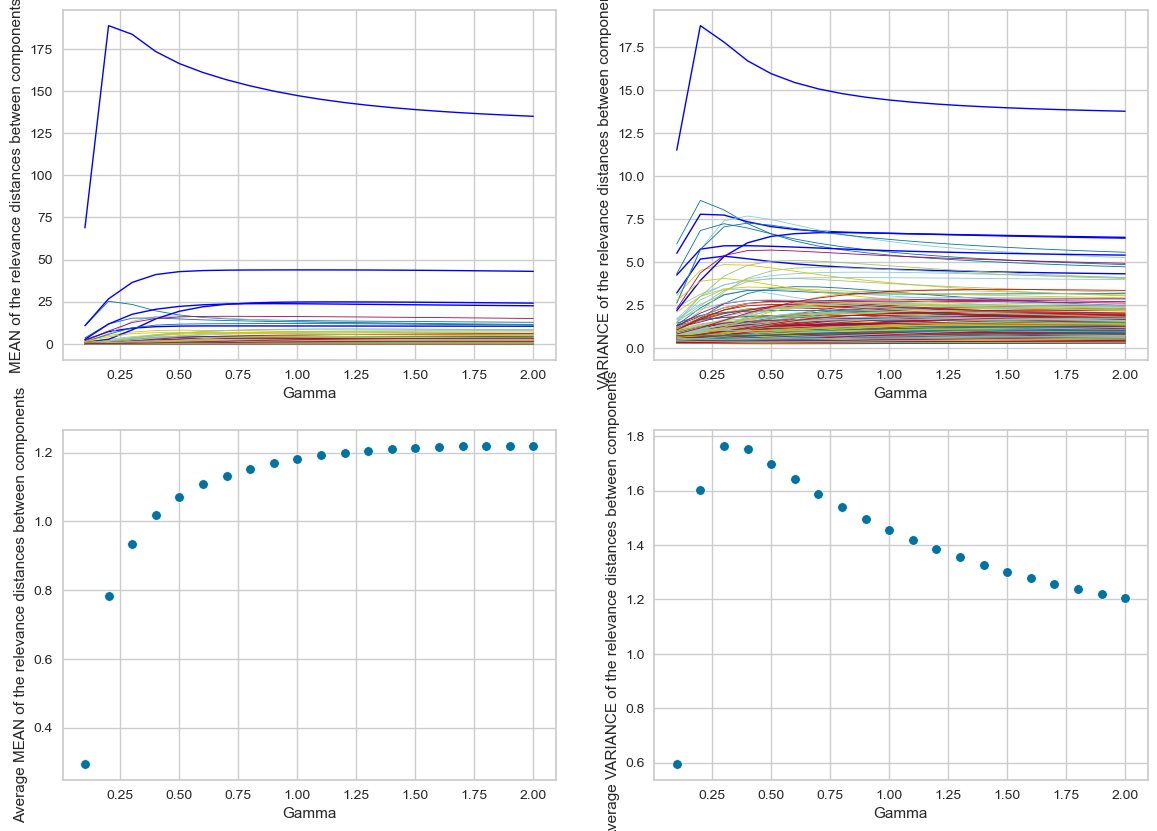

In [41]:
# Compute the mean and variance of Euclidean distances between the relevance of the components over all bootstrap samples (per instance, per gamma)

mean_dist = np.zeros((len(Rji_BS), len(gamma_range)))
var_dist = np.zeros((len(Rji_BS), len(gamma_range)))
print(mean_dist.shape)# (440, 20)

# iterate over instances
for item in range(len(Rji_BS)):
    # iterate over gammas
    for g in range(len(gamma_range)):
        #stats of pairwise distances between the 100 observations in 6-dim space
        mean_dist[item, g] = np.nanmean(distance.pdist(Rji_BS[item, :, g, :]))
        var_dist[item, g] = np.nanvar(distance.pdist(Rji_BS[item, :, g, :]))

p1_functions.distance_plots(mean_dist, var_dist, gamma_range, outliers_selected.array)

It can be seen that the outlier points tend to possess more distant component attribution values and these distances vary more.
The general trend is larger distances between component relevance  scores for higher gammas.
In terms of variance of the distances, it starts very low, peaks quickly and the slowly falls down.

#### Component-wise computations

For each item we calculate statistics of the anomaly attribution scores over each bootstrap sample. We compute this measure for all gammas. The statistics include mean, variance, and standard deviation.
We plot the values of the anomaly attribution mean and then variance per feature against the gamma values and mark the outliers in blue.

In [42]:
# Get the statistics over bootstraps
bootstrap_mean = np.nanmean(Rji_BS, axis=1) # all items mean over the boostraps for all gammas for all features
bootstrap_variance = np.nanvar(Rji_BS, axis=1) # all items variance over the boostraps for all gammas for all features
bootstrap_std = np.nanstd(Rji_BS, axis=1) # all items std over the boostraps for all gammas for all features

bootstrap_variance.shape

(440, 20, 6)

We plot the values of the anomaly attribution variances per feature against the gamma values and mark the outliers in blue.

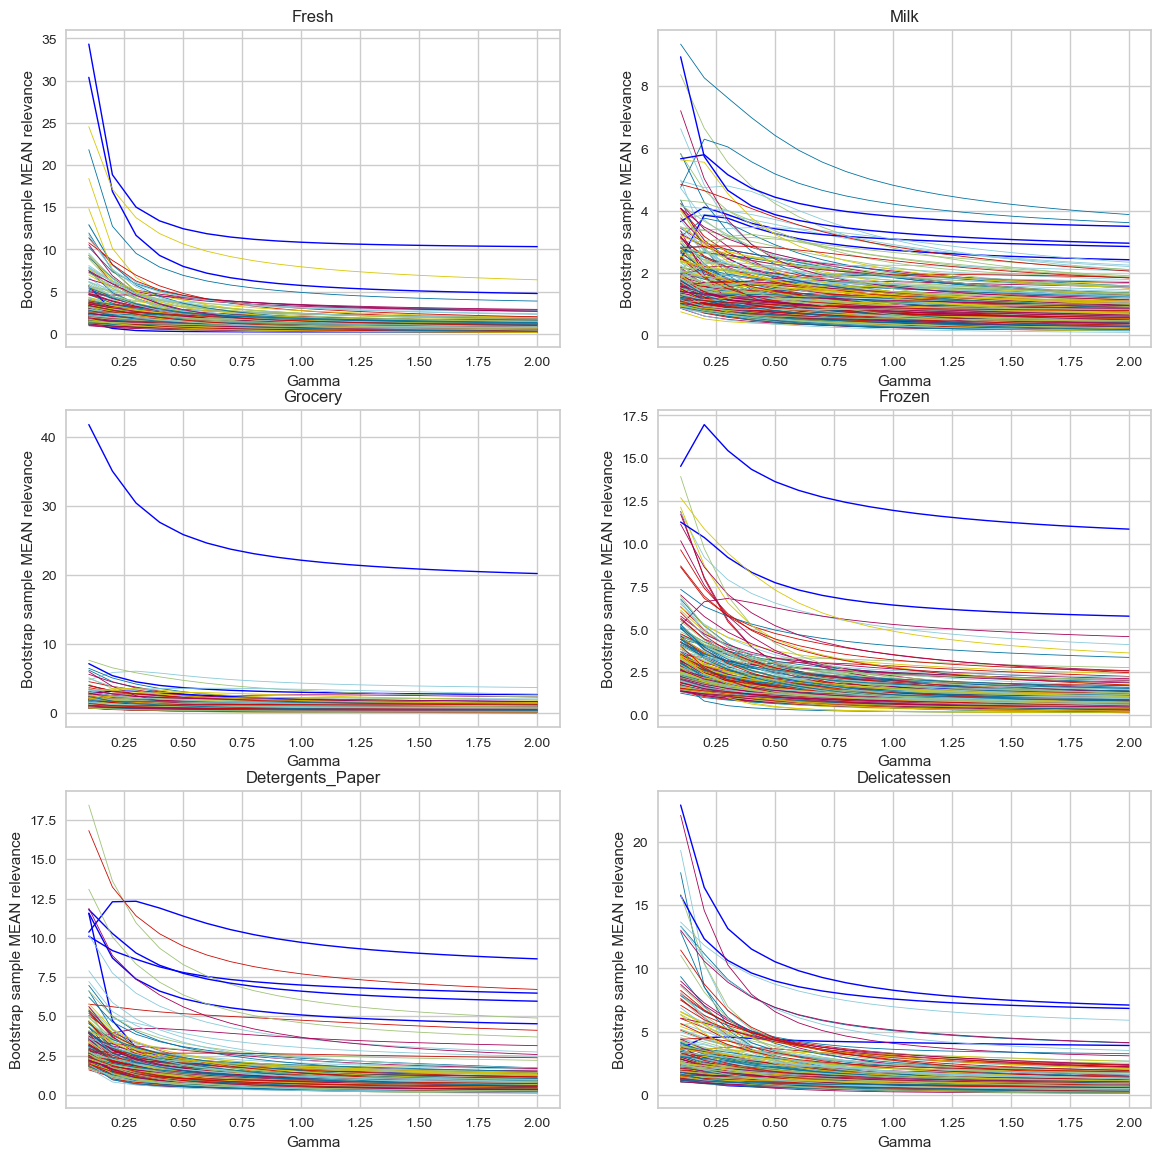

In [43]:
p1_functions.attribution_stat_plots(bootstrap_mean, gamma_range, num_features, outliers_selected.array, type = "MEAN")

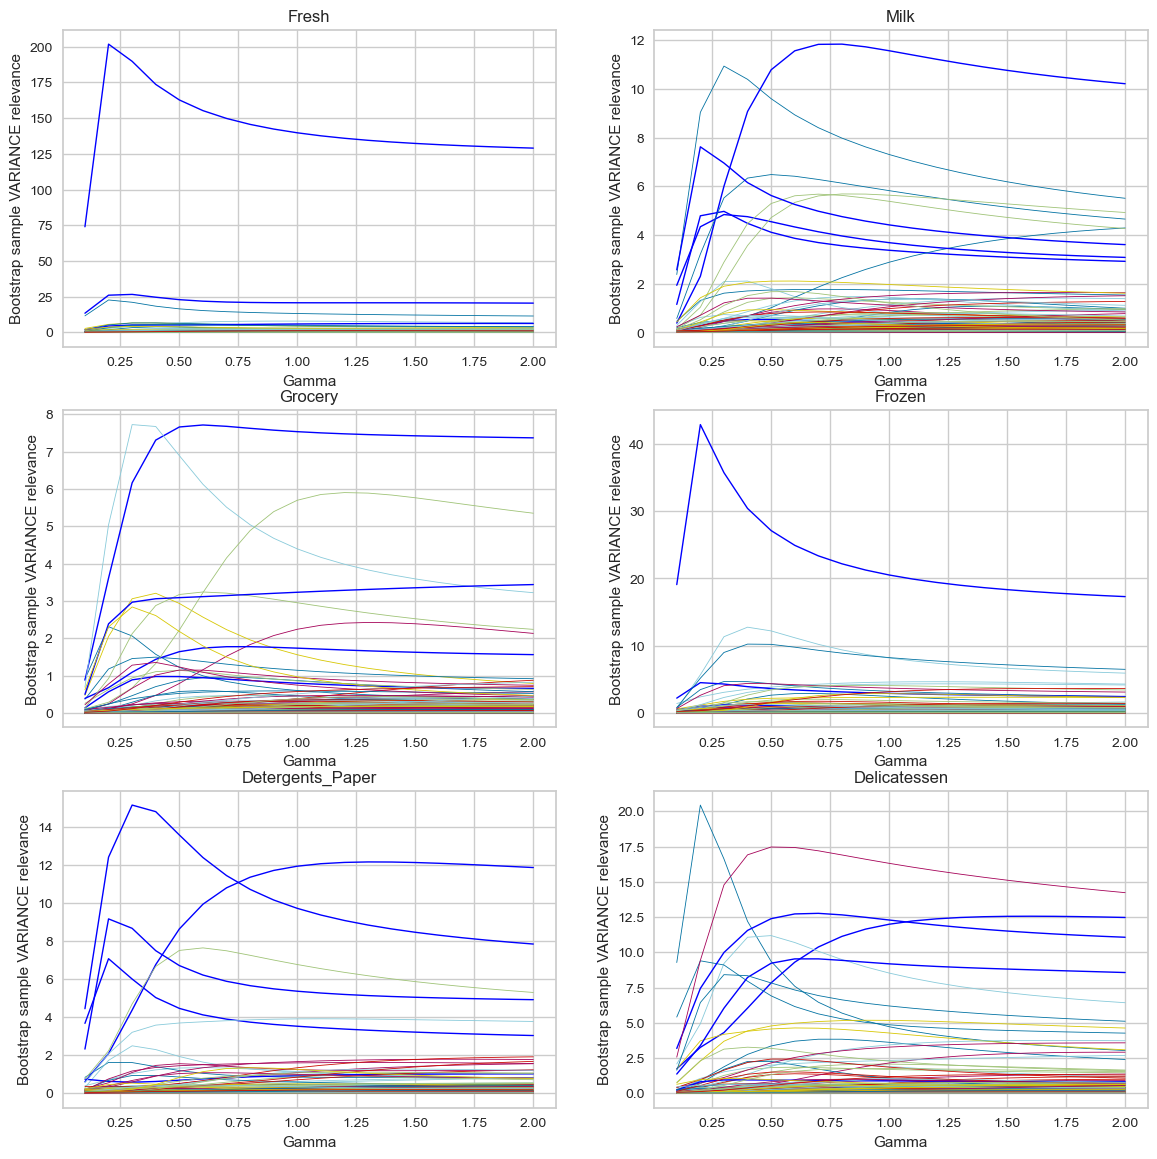

In [44]:
p1_functions.attribution_stat_plots(bootstrap_variance, gamma_range, num_features, outliers_selected.array, type = "VARIANCE")

It is visible from the plots that the highest values and the highest variation of the anomaly attribution scores is acquired by the outlier points.

We also computed the mean values of attribution variance for each feature. We plot these computations separately for inliers (all points but outliers) and outliers.

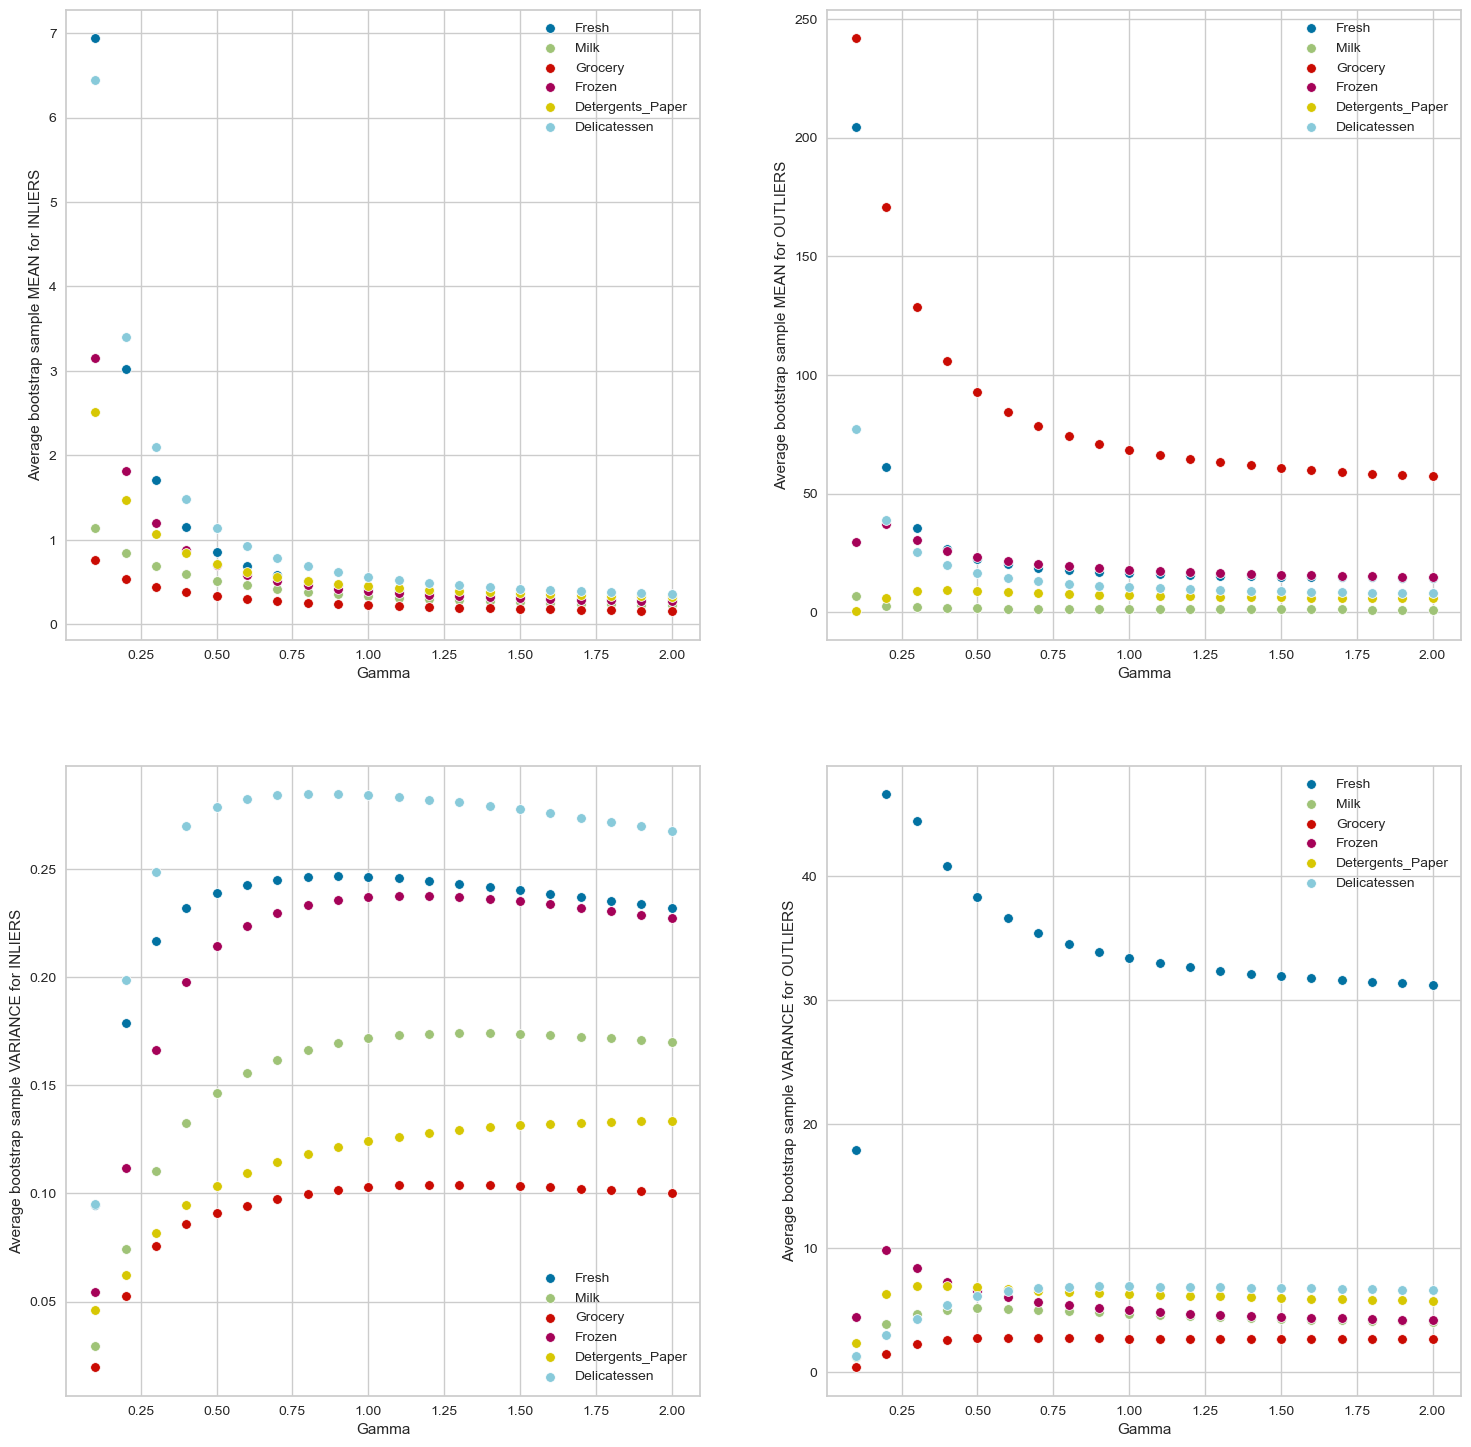

In [45]:
mask = outliers <= 15
inliers = outliers.argsort()[:sum(mask)]

from scipy import stats
#bootstrap_mean = (stats.zscore(bootstrap_mean, axis=0))
#bootstrap_variance = (stats.zscore(bootstrap_variance, axis=0))

p1_functions.attribution_variance_means(bootstrap_mean, bootstrap_variance, gamma_range, num_features, outliers_selected.array, inliers)

It can be observed that the statistics of the outlier points are in much larger ranges.
The range of the average variance for the inliers is especially narrow in comparison to that of the outliers. This implies that inlier variance is very low for all gammas, while it varies quite a lot for outliers.
Of course, this is not preferable, because we are mostly interested in robust estimate for outliers and not so much for the inliers.

 It is important to bear in mind that the ranges of the attribution scores differ per gamma. Could we apply some form of standardisation for better comparison?

### 3.2.2. Inspection of the robustness of anomaly attribution scores for gamma = 1
In order to inspect the robustness for our chosen gamma = 1, we take into account the same statistics of the experiment above only for gamma = 1

In [46]:
# Get the index if gamma = 1 from the experiment
gamma_1_index = np.argwhere(np.around(gamma_range, 1) == 1)[0,0]

# Get the statistics over bootstraps for gamma = 1
bootstrap_mean_g1 = pd.DataFrame(bootstrap_mean[:,gamma_1_index,:], columns = num_features)
bootstrap_var_g1 = pd.DataFrame(bootstrap_variance[:,gamma_1_index,:], columns = num_features)
bootstrap_var_g1.shape

(440, 6)

We compute boxplots with the mean and variance of the outlier attribution scores over the bootstrap samples.
For this computation we use 36 outlier instances since we are really interested in the robustness of the estimations for the outlier scores. We increased the number of outliers for more meaningful statistics.

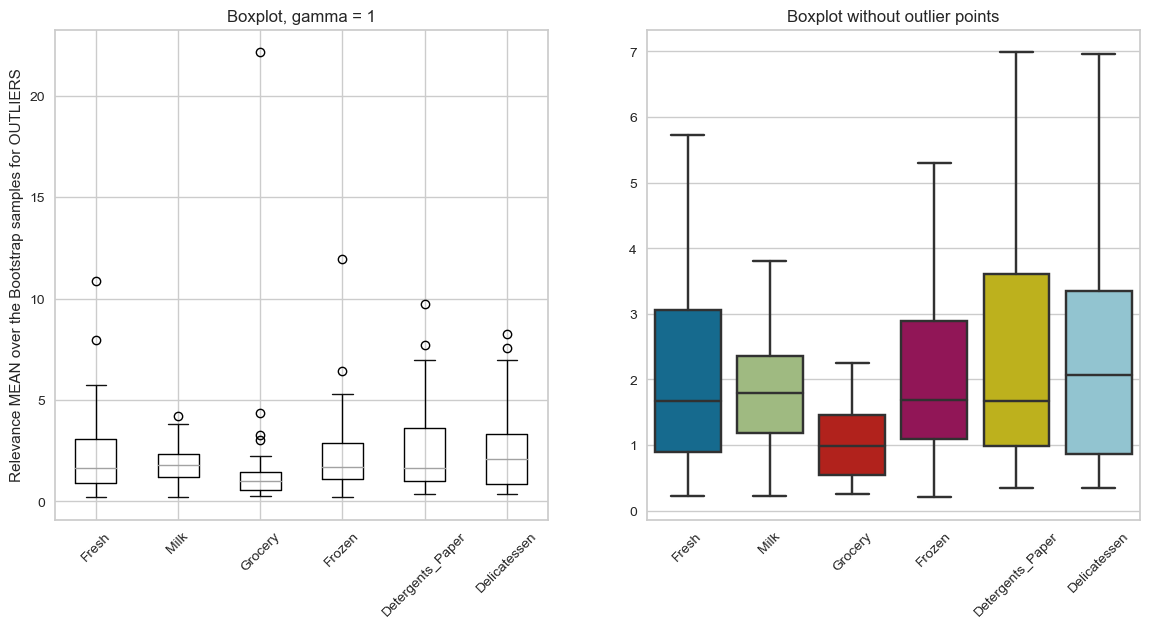

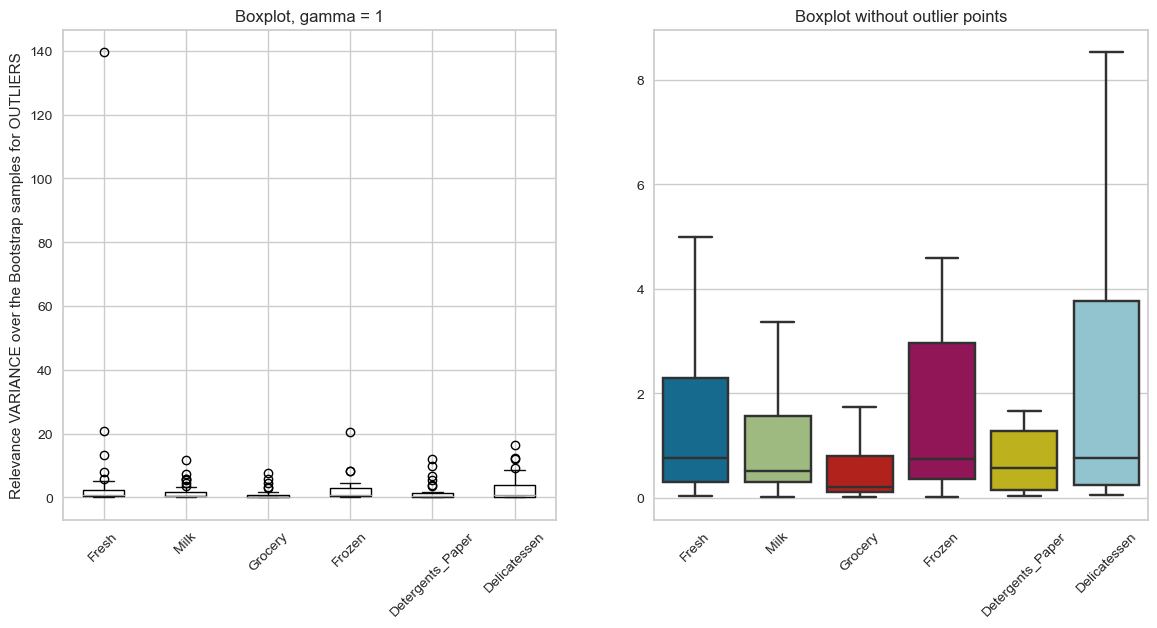

In [47]:
# The scores are already computed for gamma = 1
outliers = df_overview["outlier_score_softmin"]

mask = outliers > max
outliers_selected = outliers.argsort()[::-1][:sum(mask)]

p1_functions.attribution_boxplots(bootstrap_mean_g1.iloc[outliers_selected, :], "MEAN")
p1_functions.attribution_boxplots(bootstrap_var_g1.iloc[outliers_selected, :], "VARIANCE")

p1_functions.attribution_boxplots(bootstrap_var_g1.iloc[outliers_selected, :], "VARIANCE")
We can observe that in both the mean and variance of the outlier attribution scores there are many outlier samples within this set of outliers throughout the components. This is not ideal.

At the same time, the sample variance medians are relatively low for all components which shows median tendency to robustness. Only the variance for delicatessen is having a high spread.

The median values at the means let us compare which components tend to be responsible for high outlierness. Grocery is the least contributing feature, followed by milk, while the other features are more likely contributors to high outlierness.

### 3.2.3. Inspection of accuracy
We want inspect the "accuracy" of the estimated relevance of each component by the Bootstrap experiment. For this, we use the relevance attribution scores computed for the whole dataset and compute product moment correlation

In [48]:
# Compare the "ground truth" attribution scores with the boostrap sample means
for i, feature in enumerate(num_features):
    corr, _ = stats.pearsonr(Rji[:,i], bootstrap_mean_g1.iloc[:,i])
    corr_outliers, _ = stats.pearsonr(Rji[outliers_selected,i], bootstrap_mean_g1.iloc[outliers_selected,i])
    print(f"{feature}: all data: {corr:.2} \n       outliers: {corr_outliers:.2}")

Fresh: all data: 0.67 
       outliers: 0.53
Milk: all data: 0.86 
       outliers: 0.72
Grocery: all data: 0.96 
       outliers: 0.98
Frozen: all data: 0.92 
       outliers: 0.95
Detergents_Paper: all data: 0.95 
       outliers: 0.95
Delicatessen: all data: 0.86 
       outliers: 0.86


# 4. Cluster Analysis

Since the data does not appear to have natural cluster formations, and DBSCAN algorithm was not finding any bigger clusters, we decided to use K-means clustering algorithm. This was we can partition wholesale cusptmers into groups of relatively similar size that share tendencies in their spending.

In [49]:
# Remove the selected outlier points
outliers = df_overview["outlier_score_softmin"]
mask = outliers > 15
outliers_selected = outliers.argsort()[::-1][:sum(mask)]

df = df.drop(labels=outliers_selected, axis=0)

## 4.1. Selecting K parameter for K-means

Compute visualisation to identify the optimal inflection point for K in [2, 15]:
* elbow (distortion score): the sum of squared distances from each point to its assigned center:
* silhouette score: the mean Silhouette Coefficient of all samples;
* Calinski-Harabasz score: the ratio of dispersion between and within clusters.

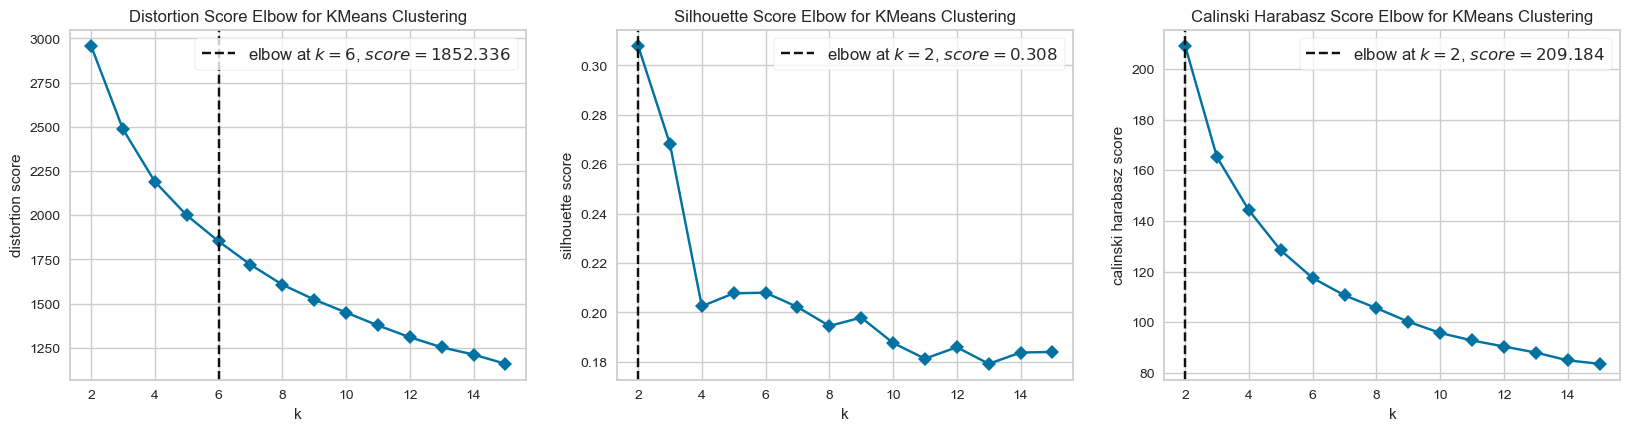

In [50]:
# K-means initialised with greedy k-means++ algorithm, over 100 initialisations
kmeans = KMeans(init="k-means++", n_init=100, random_state=42)

fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(2,3)
ax = {}

for i, metr in zip(range(3), ['distortion', 'silhouette', 'calinski_harabasz']):
    ax[i] = fig.add_subplot(gs[i])
    ax[i] = visualizer = KElbowVisualizer(kmeans, k=(2,16), metric=metr, timings=False, show=True)
    visualizer.fit(df)
    visualizer.finalize()

plt.show()

Observation:

There is no clear infliction point in the elbow plot of the distoriotn score, we can assume K = 6 to be a reasonable trade-off point. Similar result is obtained by computing the Calinski-Harabasz index.
The silhouette score is strongly reduced for K > 3, however we assume that more than three clusters is reasonable in order to partition the customers in this application.

#### In addition we perform K-means clustering for K in the range [2, 6] and inspect the silhouette scores for the clusters.

For n_clusters = 2 The average silhouette_score is : 0.3080346759600634
For n_clusters = 3 The average silhouette_score is : 0.2682074590083796
For n_clusters = 4 The average silhouette_score is : 0.20251584387938656
For n_clusters = 5 The average silhouette_score is : 0.20774528277992896
For n_clusters = 6 The average silhouette_score is : 0.20799562310732864
For n_clusters = 7 The average silhouette_score is : 0.2022074933051771
For n_clusters = 8 The average silhouette_score is : 0.19452293217673183


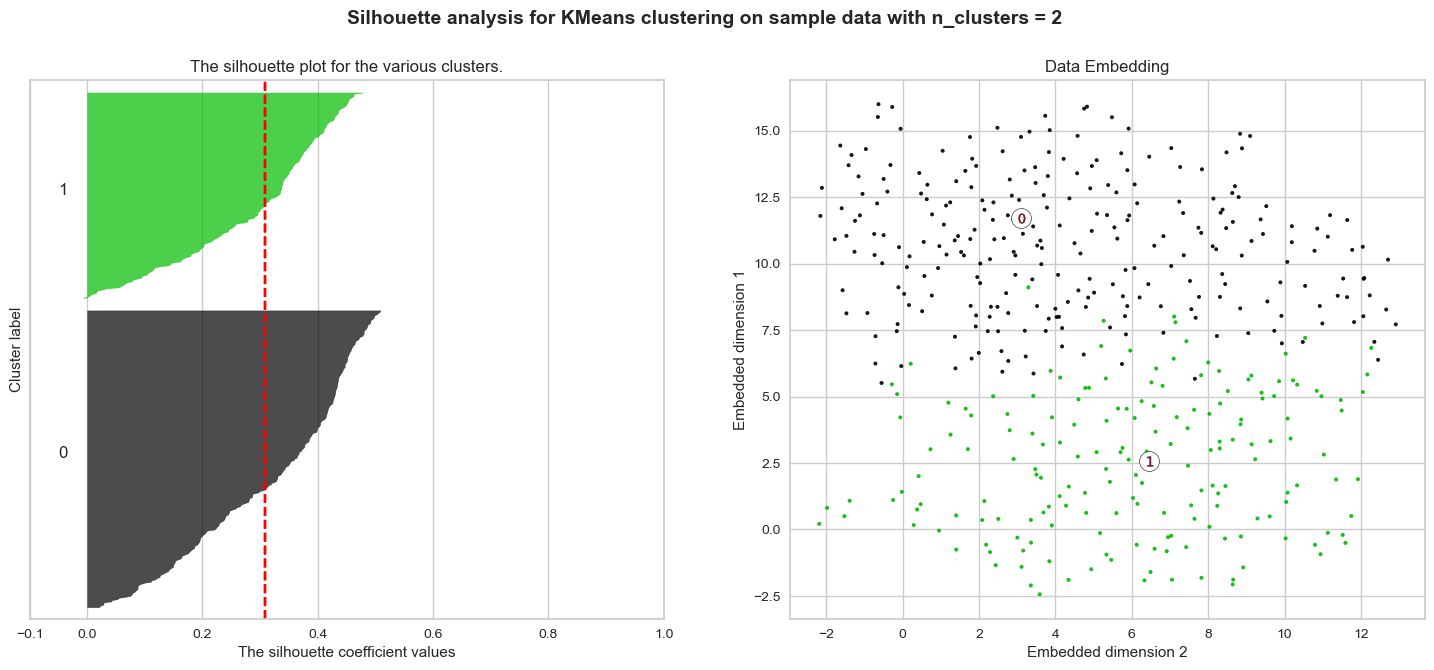

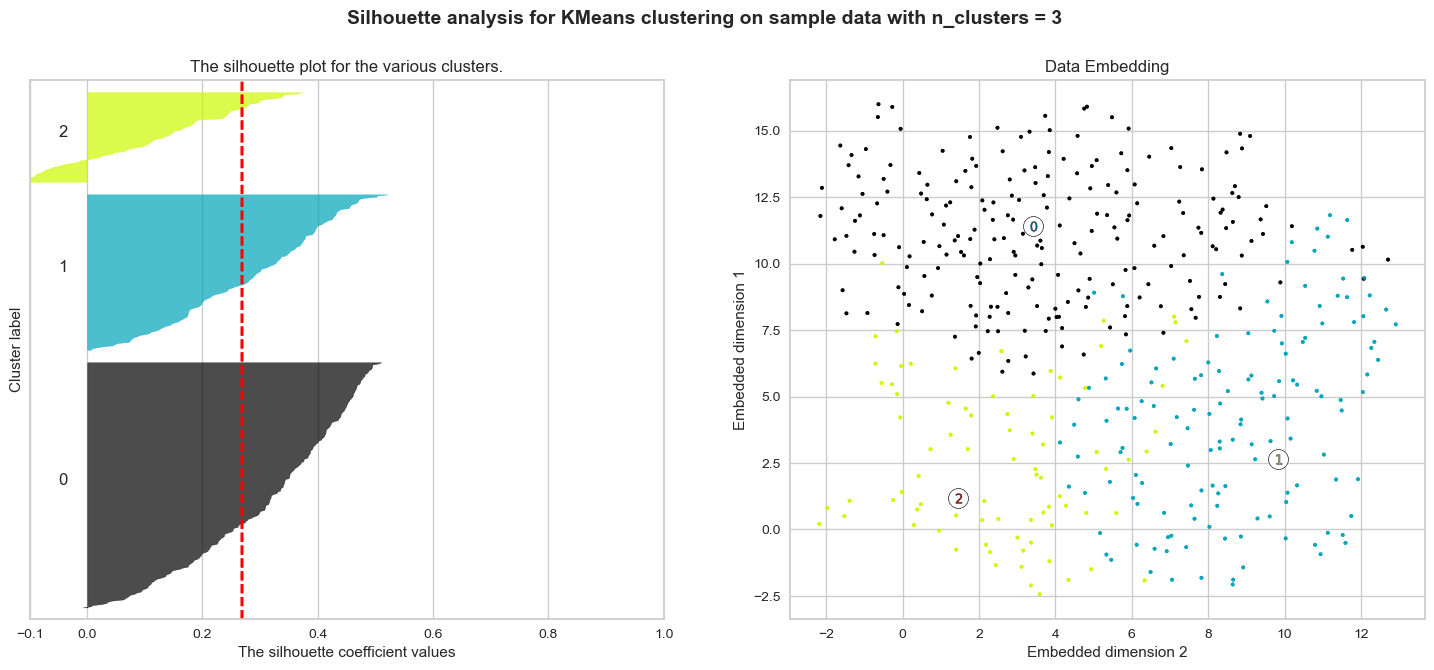

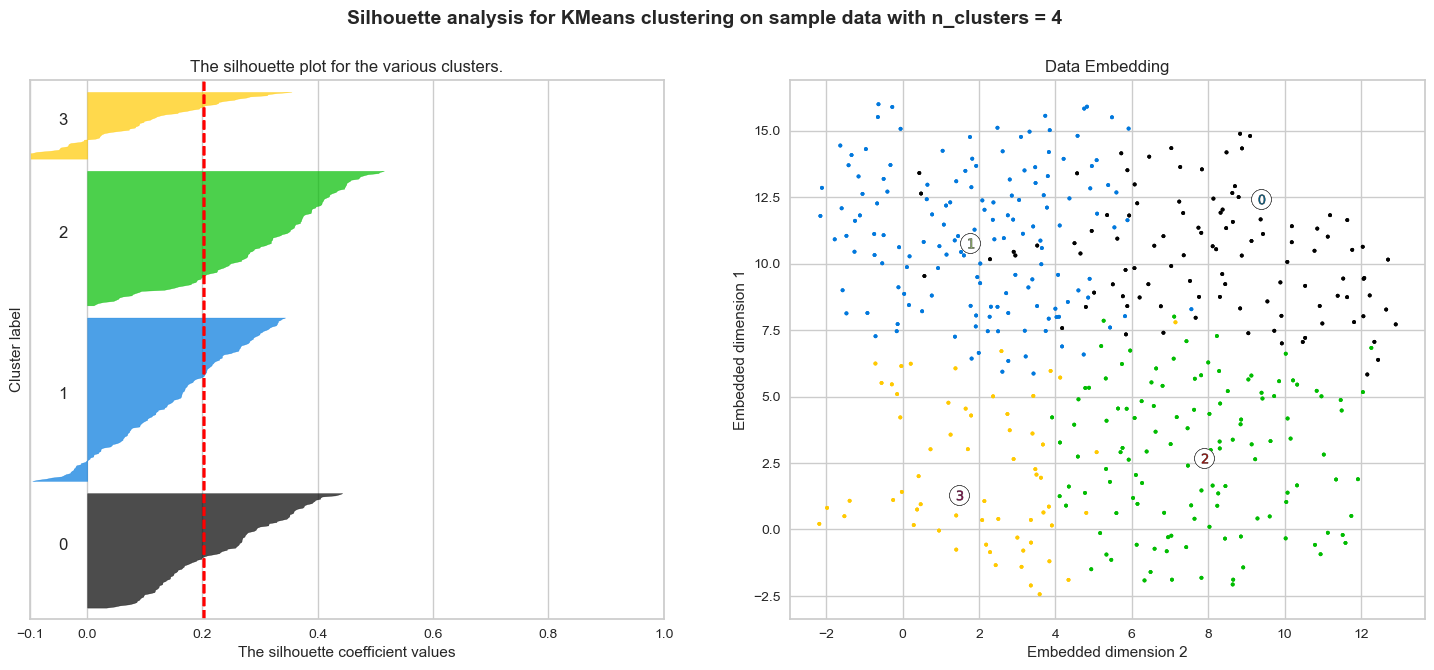

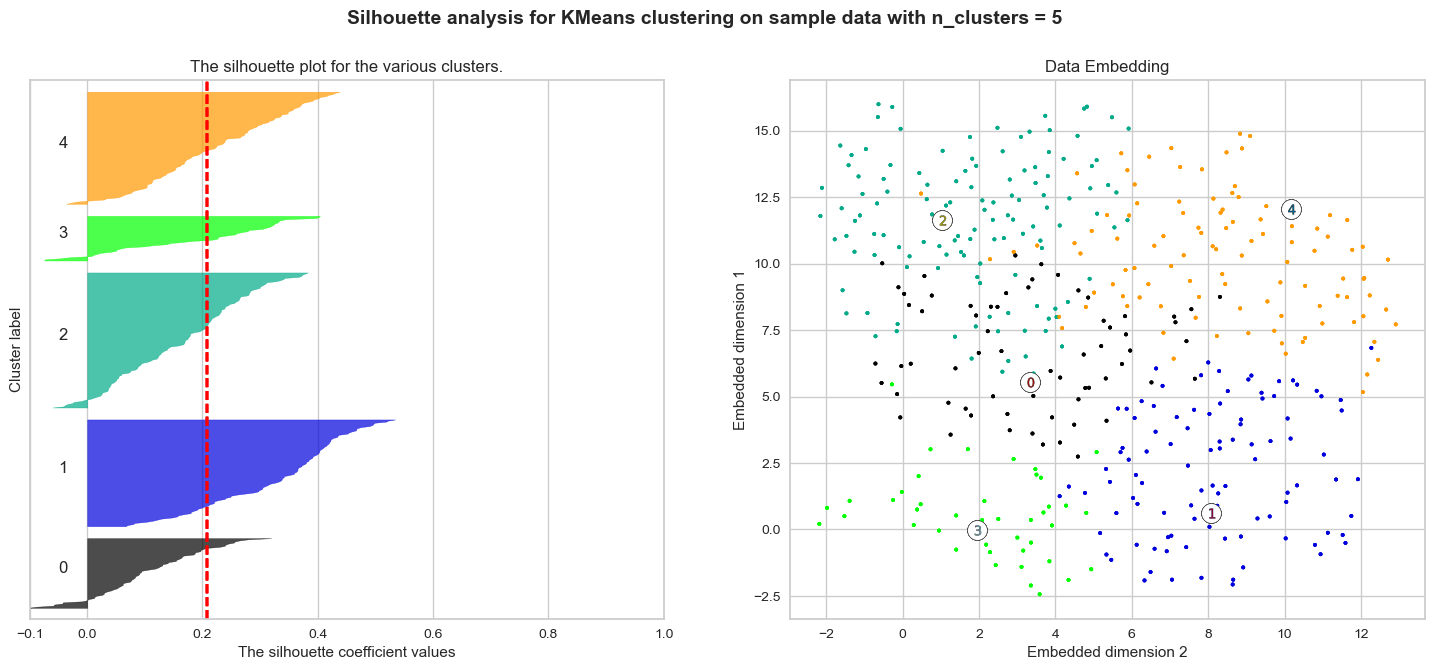

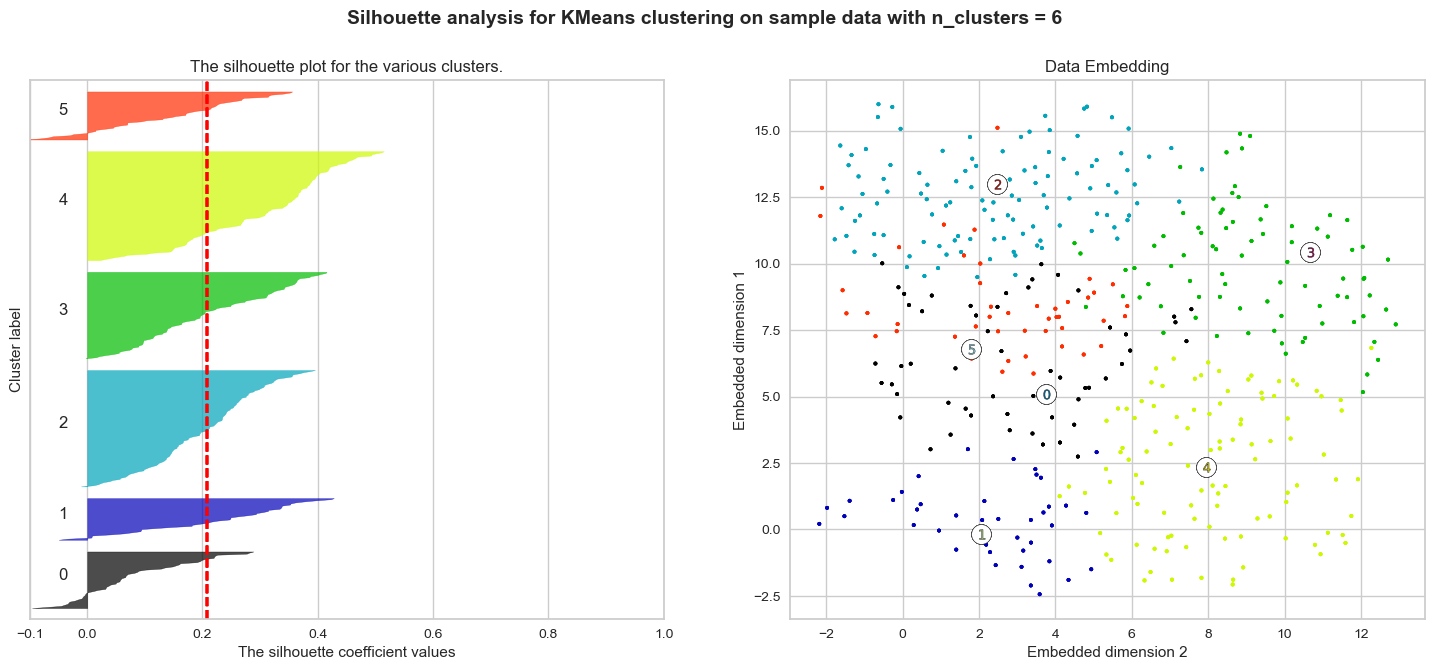

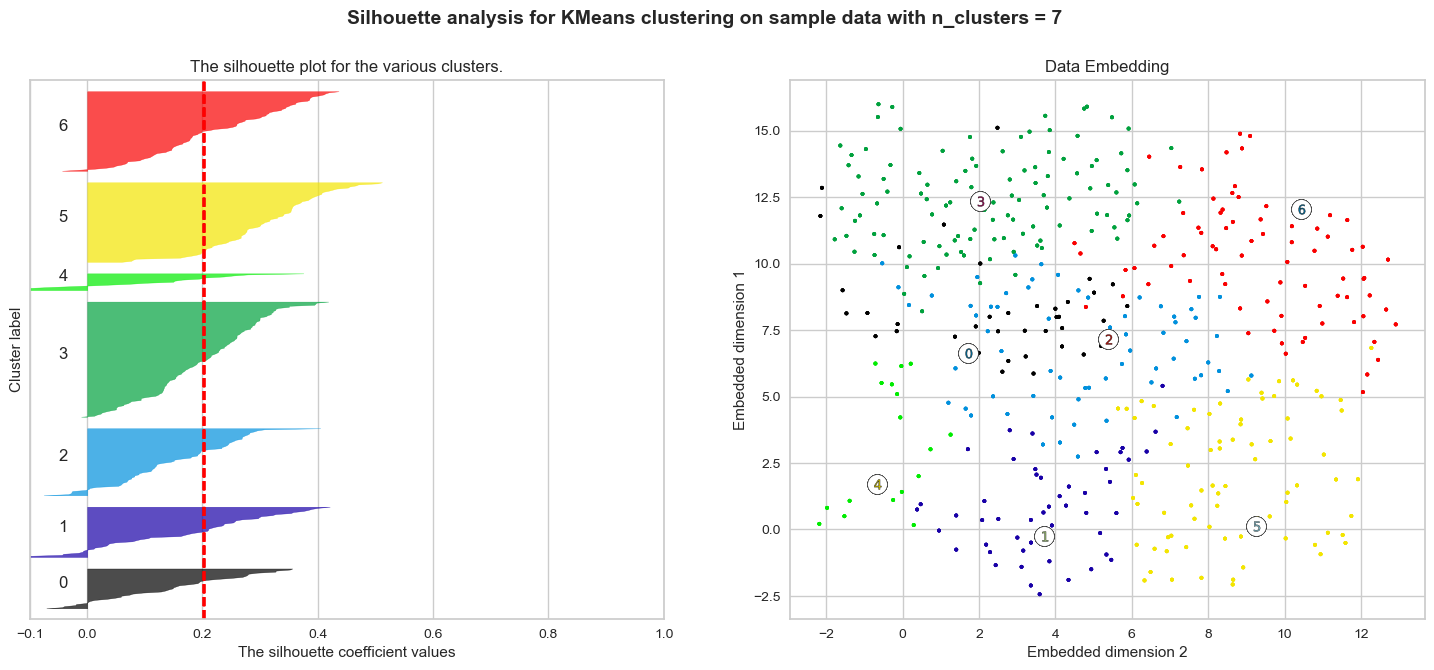

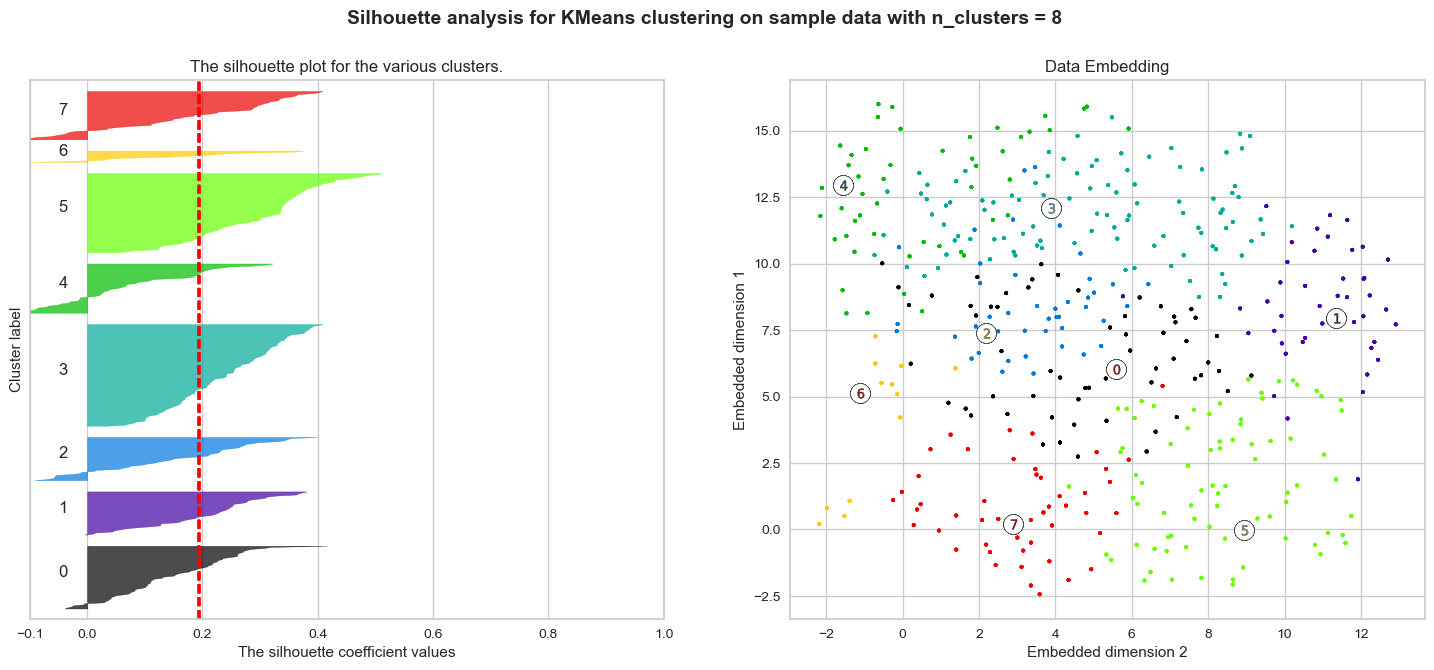

In [51]:
p1_functions.silhouette_analysis(min_k=2, max_k=8, X=df, Umap=True)

Observation:

It seems that the most plausible solution for K > 3 is K = 5 or K = 6. The silhouette scores are overall not very satisfying, but they are a bit higher for these two clusterings. As for individual clusters, the clustering with K = 6 has a small cluster with index 0, which in not having a high score, but seems to allow reorganisation and slightly better scoring for the other clusters. Both these options could be reasonable and would need to be discussed in the context of the application. Since we do not have this context, we fix K to six as this number of clusters also provides a lower distortion score.

## 4.2. Clustering

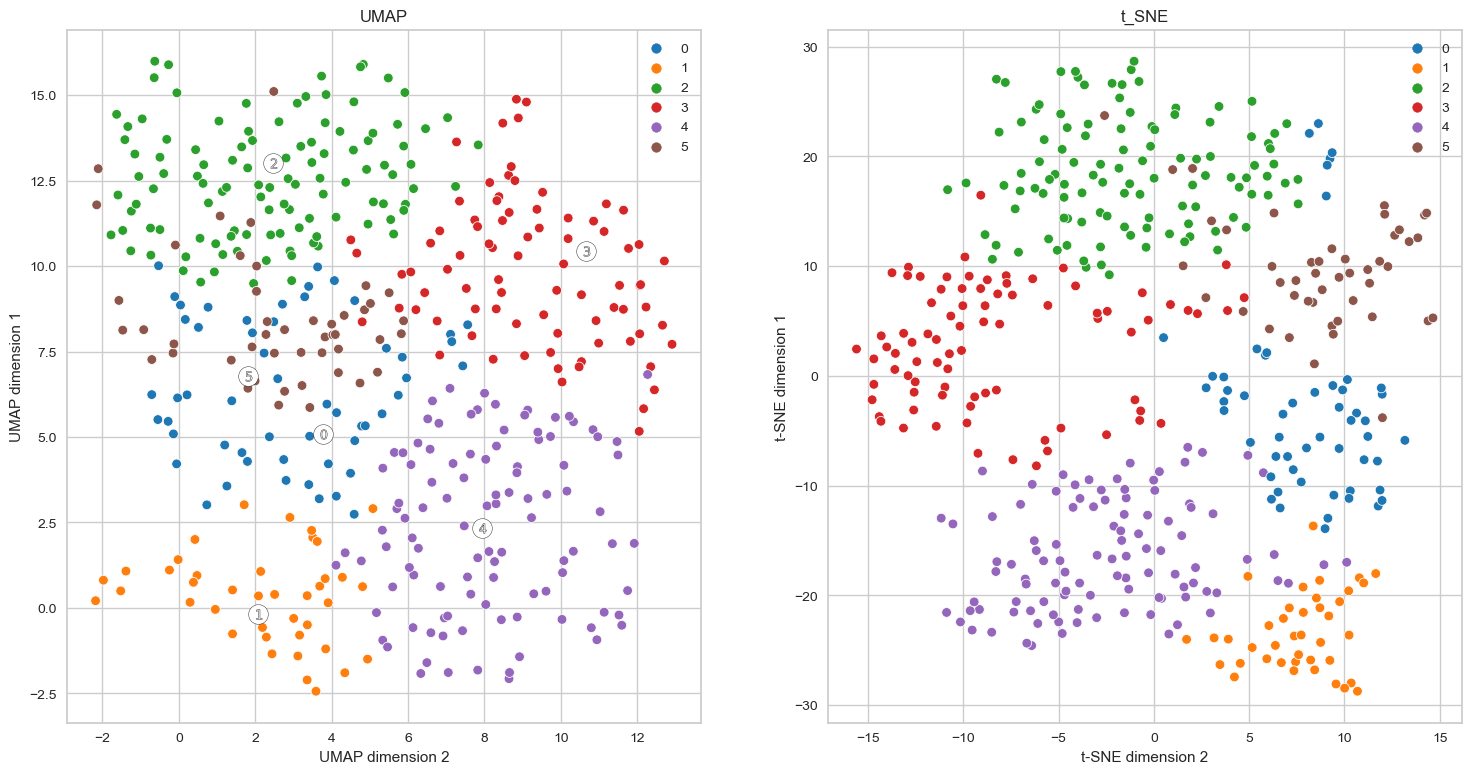

In [52]:
# Fit k-Means and visualise using UMAP and t-SNE
K = 6
kmeans = KMeans(n_clusters=K, init="k-means++", n_init=100, random_state=42).fit(df)
p1_functions.visualise_kmeans(df, kmeans)

In [53]:
print("k-Means cluster sizes:")
for cluster in set(kmeans.labels_):
    filter = kmeans.labels_ == cluster
    print("Cluster:", cluster, ":", sum(kmeans.labels_ == cluster))

k-Means cluster sizes:
Cluster: 0 : 54
Cluster: 1 : 40
Cluster: 2 : 110
Cluster: 3 : 82
Cluster: 4 : 103
Cluster: 5 : 46


## 4.3. Interpretation of the clustering
For an interpretation of the clustering, we plot average spending of cluster members for the different product categories.
We computed means and standard deviations for each category within each cluster, as well as boxplots for each clsuter within each category.

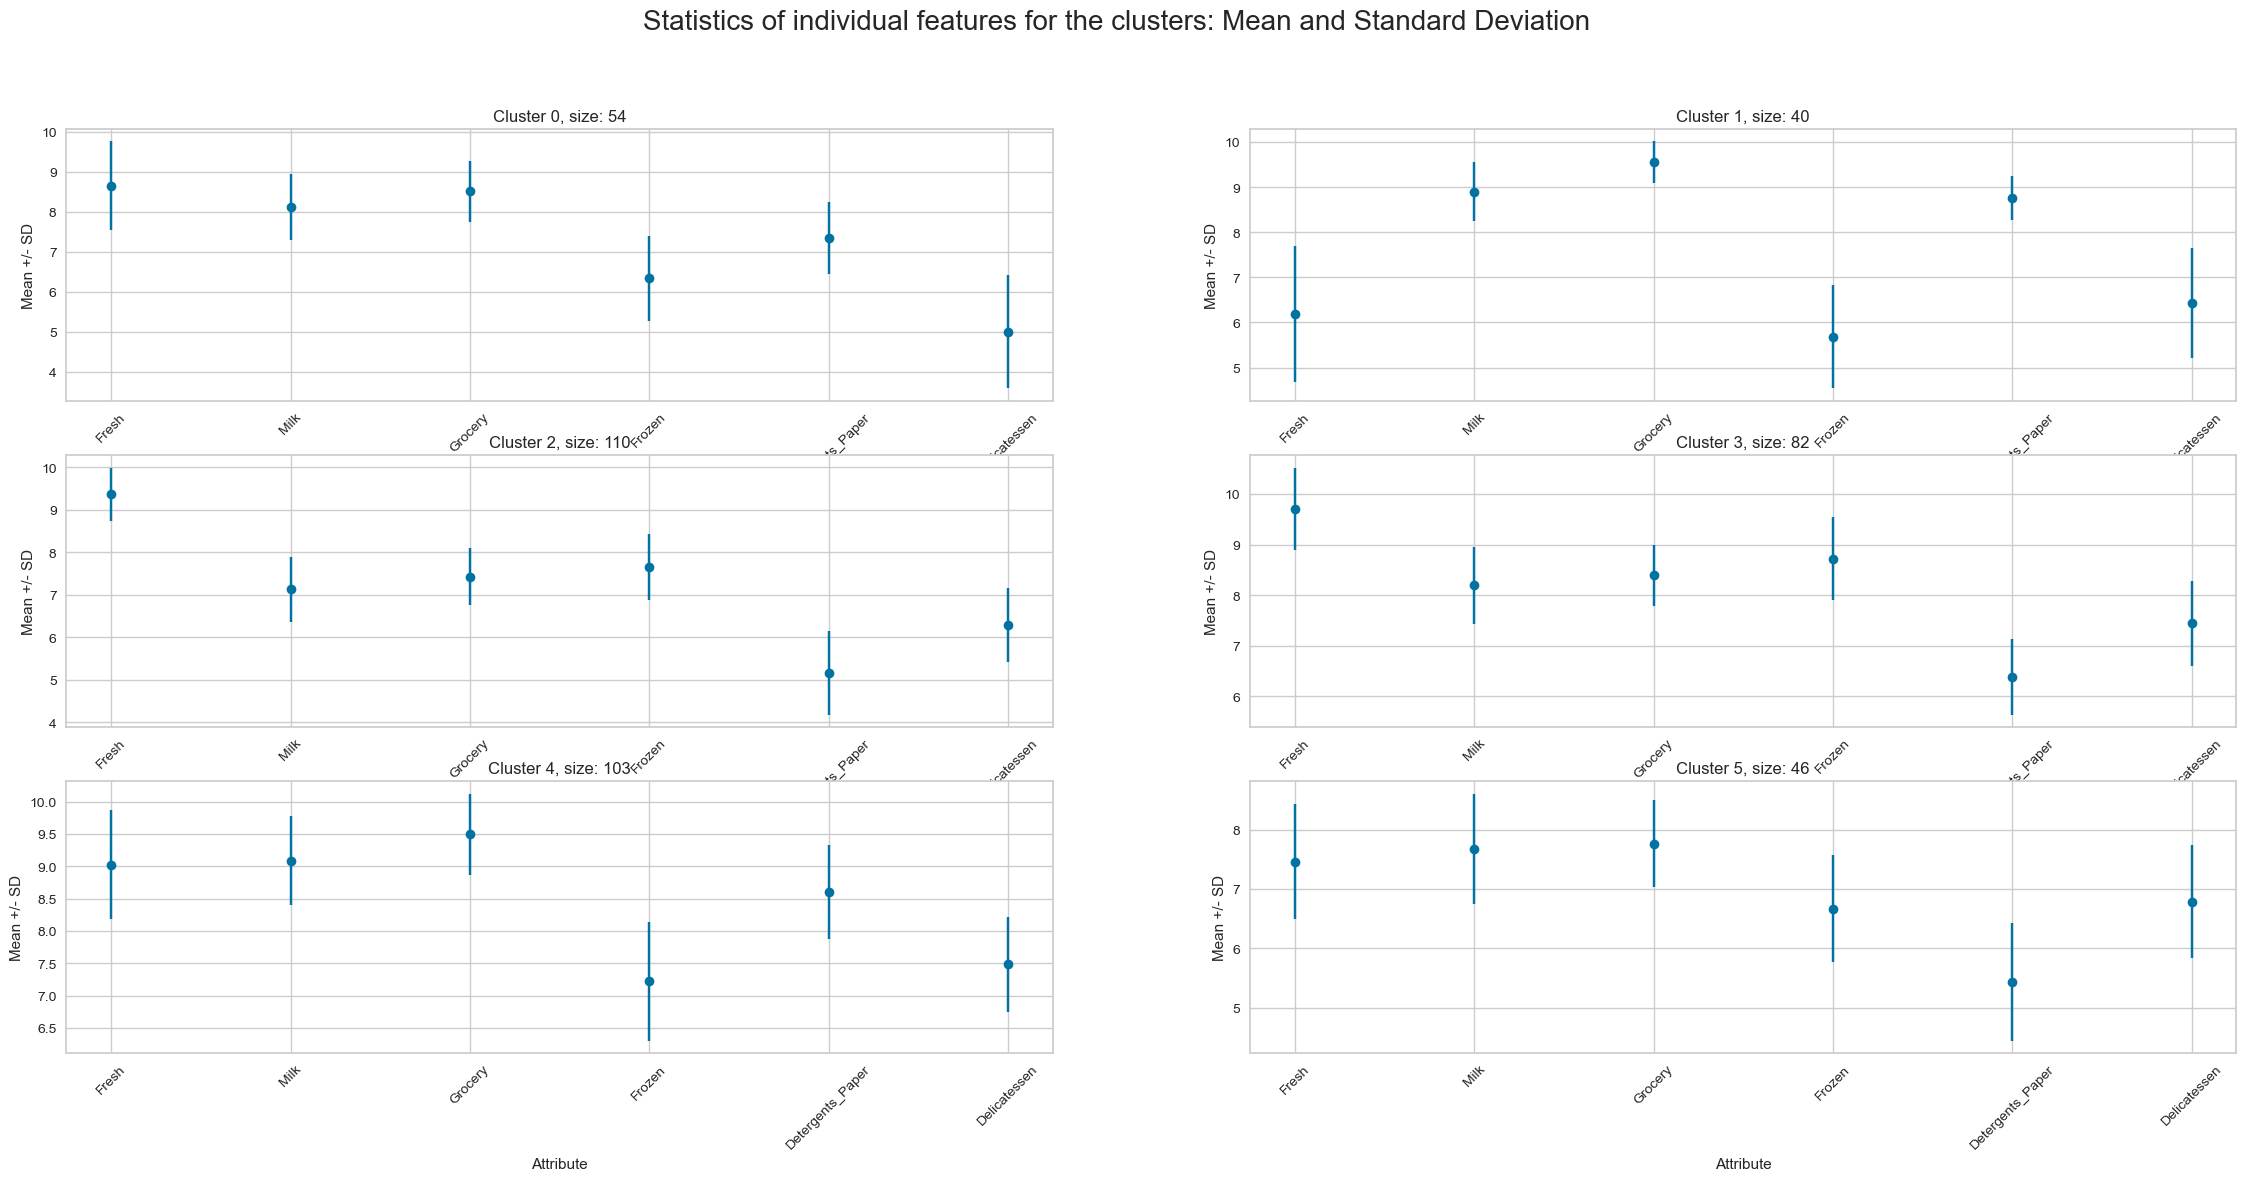

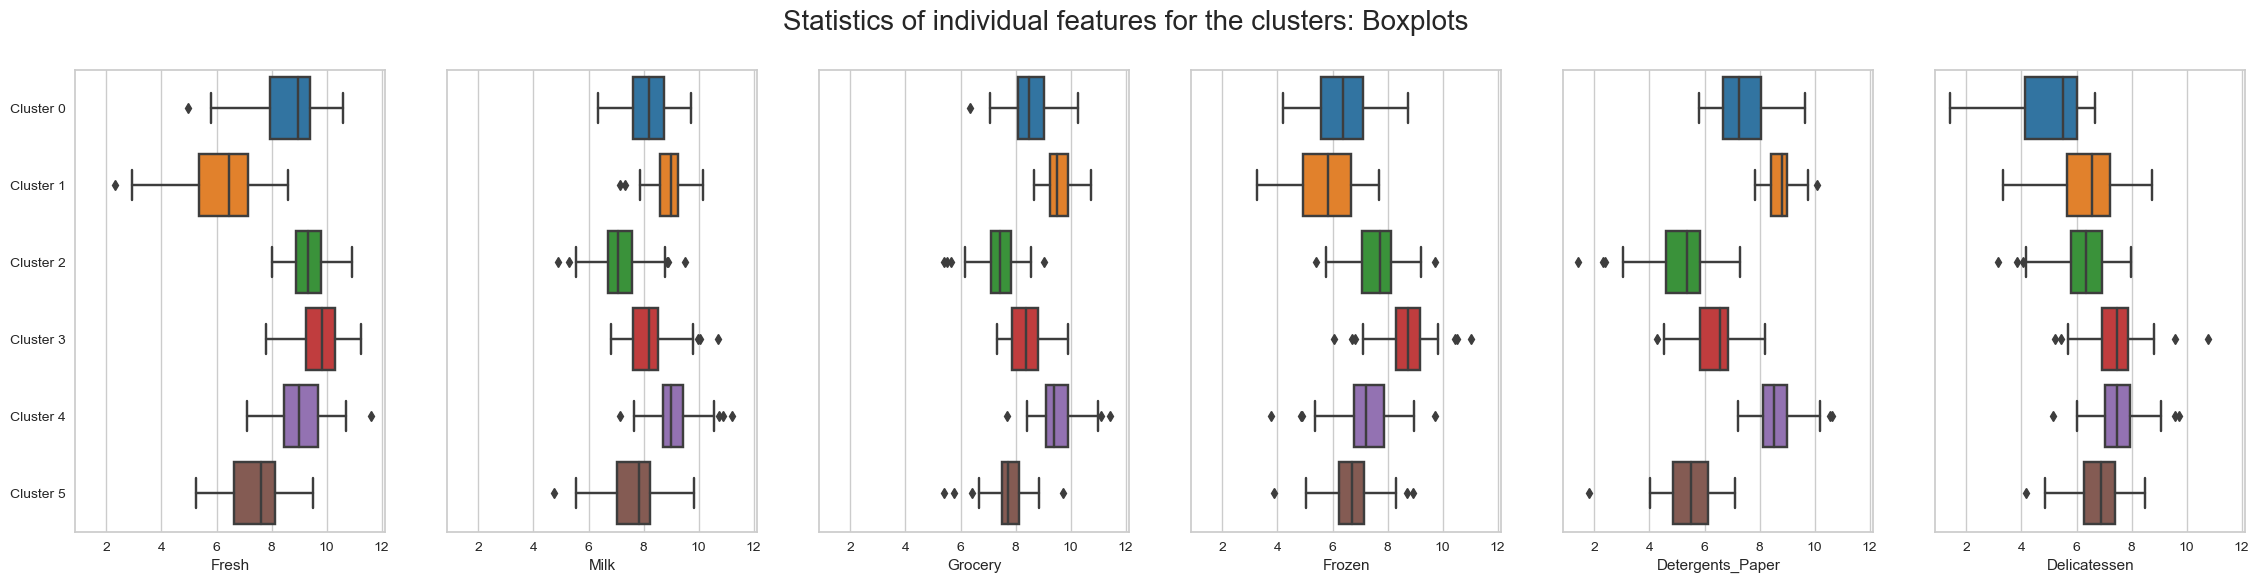

In [54]:
p1_functions.clusters_stats(df, kmeans)